# lisabeta: tutorial for basics of the interface and MBHB sky localization

This notebook describes basics about lisabeta, a package for gravitational wave data analysis for the instrument LISA.

lisabeta is now publicly available here:

[https://gitlab.in2p3.fr/marsat/lisabeta](https://gitlab.in2p3.fr/marsat/lisabeta)
    
[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/SylvainMarsat/lisabeta_sky_tutorial/blob/main/lisa_mbhb_sky_tutorial.ipynb)

## Installation on Google Colab

In [ ]:
!apt-get install libgsl-dev
!gsl-config --prefix
!apt-get install fftw3-dev

In [ ]:
!apt-get install cm-super dvipng texlive-latex-extra texlive-latex-recommended #needed to support tex in matplotlib (takes just over 1 min)

In [ ]:
!git clone https://github.com/SylvainMarsat/lisabeta_sky_tutorial.git
!ln -s lisabeta_sky_tutorial/example_pe .
!git clone --recursive --depth=1 https://gitlab.in2p3.fr/marsat/lisabeta.git lisabeta_code
!sed -i.bak 's\/path/to/gsl\/usr:/usr/local\g;s\:/path/to/LDC/ldc/common/constants\\' lisabeta_code/setup.cfg

In [ ]:
%pip install ./lisabeta_code

## Imports

In [166]:
import os
import h5py
import itertools
import copy
import numpy as np
import scipy
import json
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm as tqdm

from astropy.cosmology import Planck15 as cosmo

In [167]:
import lisabeta
import lisabeta.pyconstants as pyconstants
import lisabeta.tools.pytools as pytools
import lisabeta.tools.pyspline as pyspline
import lisabeta.tools.pyoverlap as pyoverlap
import lisabeta.lisa.pyresponse as pyresponse
import lisabeta.lisa.snrtools as snrtools
import lisabeta.lisa.pyLISAnoise as pyLISAnoise
import lisabeta.lisa.lisa as lisa
import lisabeta.lisa.lisatools as lisatools
import lisabeta.lisa.lisa_fisher as lisa_fisher
import lisabeta.utils.plotutils as plotutils

In [168]:
np.set_printoptions(legacy='1.25')
%matplotlib inline

# A quick look at the lisabeta interface

## Setting parameters

In [4]:
# Redshift z=6
cosmo.luminosity_distance(6.).value

59046.10457286159

The **LISA-frame** (Lframe): frame where the x-y-plane is the plane of LISA at the time of merger. Useful in understanding degeneracies for transient signals such as MBHBs.

In [5]:
# Physical signal parameters
# NOTE: Lframe is a flag that changes the meaning of several parameters: when on, lambda, beta, psi and Deltat all refer to the LISA-frame
# NOTE: all masses in the code are understood as redshifted, detector-frame masses

params = {
    # Total *redshifted* mass M=m1+m2, solar masses
    "M": 5e6,
    # Mass ratio q=m1/m2
    "q": 4.0,
    # Dimensionless spin component 1 along orbital momentum
    "chi1": 0.7,
    # Dimensionless spin component 2 along orbital momentum
    "chi2": 0.4,
    # Time shift of coalescence, s -- coalescence is at t0*yr + Deltat*s, t0 in waveform_params
    "Deltat": 0.0,
    # Luminosity distance, Mpc
    "dist": cosmo.luminosity_distance(6).value,
    # Inclination, observer's colatitude in source-frame
    "inc": 1.0471975511965976,
    # Phase, observer's longitude in source-frame
    "phi": 1.2,
    # Longitude in the sky
    "lambda": 0.5,
    # Latitude in the sky
    "beta": 0.9,
    # Polarization angle
    "psi": 2.7,
    # Flag indicating whether angles and Deltat pertain to the L-frame or SSB-frame
    "Lframe": True
  }

In [6]:
# Tool to complete the dictionary with other mass/spin combinations
pytools.complete_all_params(params)

{'M': 5000000.0,
 'q': 4.0,
 'chi1': 0.7,
 'chi2': 0.4,
 'Deltat': 0.0,
 'dist': 59046.10457286159,
 'inc': 1.0471975511965976,
 'phi': 1.2,
 'lambda': 0.5,
 'beta': 0.9,
 'psi': 2.7,
 'Lframe': True,
 'm1': 4000000.0,
 'm2': 1000000.0,
 'Mchirp': 1665106.4148037464,
 'eta': 0.16,
 'chis': 0.55,
 'chia': 0.14999999999999997,
 'chip': 0.6399999999999999,
 'chim': 0.4799999999999999,
 'chiPN': 0.5808141592920354}

In [7]:
# Parameters for the waveform generation and other options

waveform_params = {
    
    # Frequency range
    "minf": 1e-5,
    "maxf": 0.5,
    # Reference epoch of coalescence, yr -- coalescence is at t0*yr + Deltat*s, Deltat in params
    "t0": 0.0,
    # Always cut signals timetomerger_max*yr before merger -- to avoid needlessly long signals using minf
    "timetomerger_max": 2.0,
    # Option to cut the signal pre-merger -- must be in L-frame
    "DeltatL_cut": None,
    # Further options to cut signals
    "fstart22": None,
    "fend22": None,
    "tmin": None,
    "tmax": None,
    
    # Waveform approximant and set of harmonics to use (None to use all available)
    "approximant": "IMRPhenomXHM",
    "modes": None,
    
    # LISA response options
    "TDI": "TDIAET",
    "LISAconst": "Proposal",
    "responseapprox": "full",
    "frozenLISA": False,
    "TDIrescaled": True,
    
    # Noise options -- can also be given as a numpy array for interpolation
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": True,
        "WDduration" : 4.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
  }

## Waveform and response generation function

In [169]:
# Generate waveform and LISA transfer functions separately
wftdi = lisa.GenerateLISATDI_SMBH(params, **waveform_params)

In [170]:
%timeit lisa.GenerateLISATDI_SMBH(params, **waveform_params)

1.24 ms ± 45.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [171]:
wftdi.keys()

dict_keys(['params', 'modes', 'fpeak', 'Mfinal', 'chifinal', (2, 2), (2, 1), (3, 3), (3, 2), (4, 4)])

In [11]:
# List of modes
wftdi['modes']

[(2, 2), (2, 1), (3, 3), (3, 2), (4, 4)]

In [12]:
# Each mode has its own amplitude, phase, Doppler phase, transfer functions
wftdi[(2,2)].keys()

dict_keys(['freq', 'amp', 'phase', 'tf', 'phaseRdelay', 'transferL1', 'transferL2', 'transferL3'])

In [172]:
# The data is represented on a sparse set of frequencies
wftdi[(2,2)]['freq'].shape[0]

308

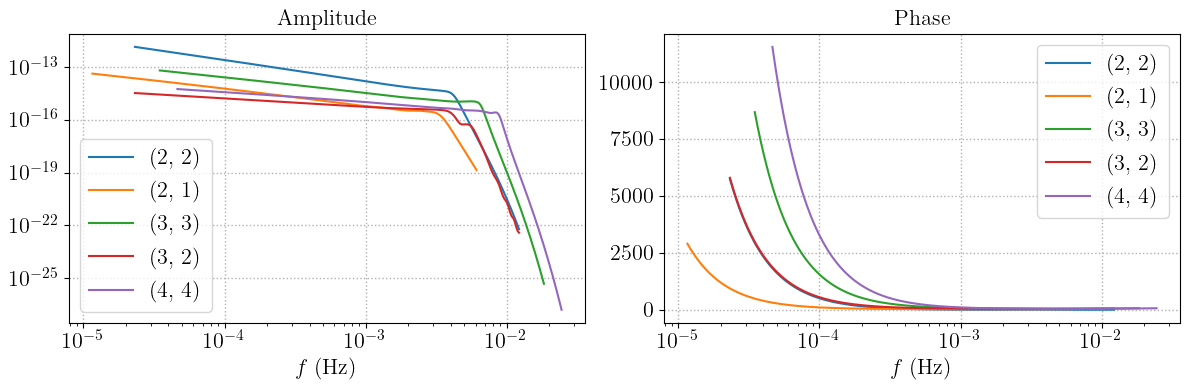

In [173]:
# Amplitude and phase of the hlm in the waveform

fig, axs = plt.subplots(1,2, figsize=[12,4])
for lm in wftdi['modes']:
    axs[0].plot(wftdi[lm]['freq'], np.abs(wftdi[lm]['amp']), label=str(lm))
    axs[1].plot(wftdi[lm]['freq'], np.abs(wftdi[lm]['phase']), label=str(lm))
for i in range(2):
    axs[i].set_xscale('log')
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
axs[0].set_yscale('log')
axs[0].legend(loc='lower left')
axs[1].legend(loc='upper right')
axs[0].set_title(r'Amplitude')
axs[1].set_title(r'Phase')
fig.tight_layout()

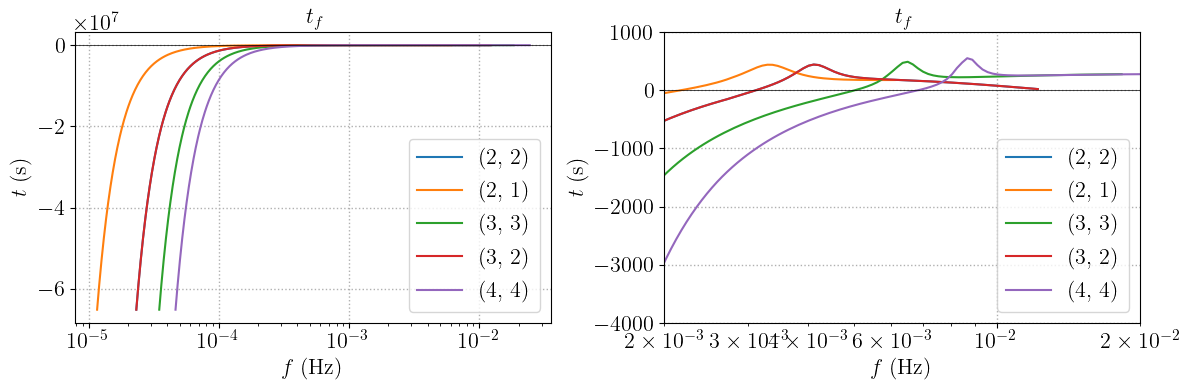

In [174]:
# Time-of-frequency correspondence

fig, axs = plt.subplots(1,2, figsize=[12,4])
for lm in wftdi['modes']:
    axs[0].plot(wftdi[lm]['freq'], wftdi[lm]['tf'], label=str(lm))
    axs[1].plot(wftdi[lm]['freq'], wftdi[lm]['tf'], label=str(lm))
    axs[1].set_xlim(2e-3, 2e-2)
    axs[1].set_ylim(-4e3, 1e3)
for i in range(2):
    axs[i].set_xscale('log')
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_ylabel(r'$t \; (\mathrm{s})$')
    axs[i].axhline(0., c='k', lw=0.5)
axs[0].legend(loc='lower right')
axs[1].legend(loc='lower right')
axs[0].set_title(r'$t_f$')
axs[1].set_title(r'$t_f$')
fig.tight_layout()

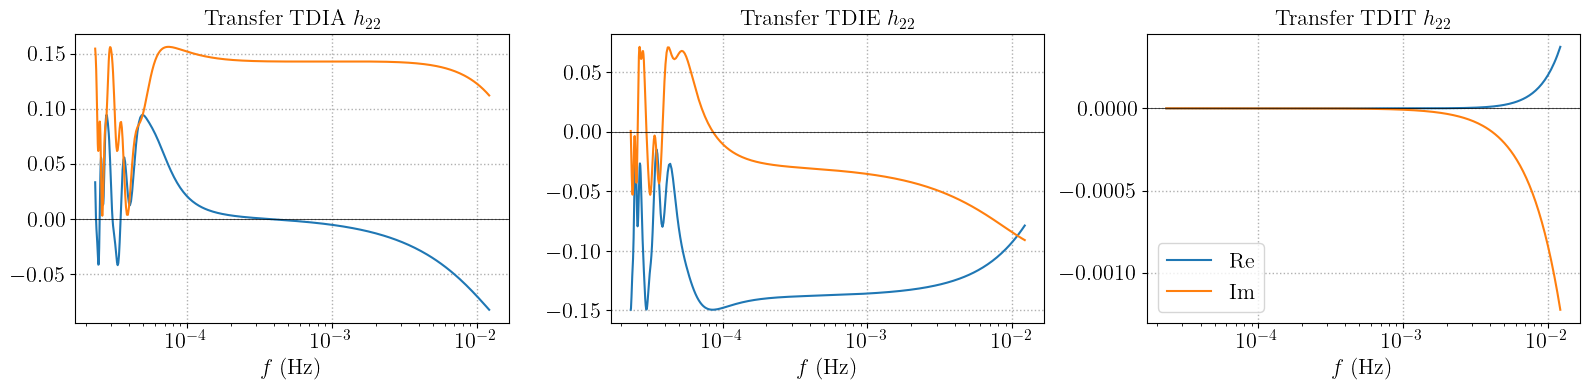

In [175]:
# Transfer functions, mode h22 (NOTE: rescaled by (6*pi*f*L/c))
titles = ['Transfer TDIA $h_{22}$', 'Transfer TDIE $h_{22}$', 'Transfer TDIT $h_{22}$']
lm = (2,2)

L = 2.5e9
rescaling = 1./(6*np.pi*wftdi[(2,2)]['freq']*L/pyconstants.C_SI)

fig, axs = plt.subplots(1,3, figsize=[16,4])
for i in range(3):
    transferstr = 'transferL' + str(i+1)
    axs[i].plot(wftdi[lm]['freq'], np.real(wftdi[lm][transferstr]) * rescaling, label='Re')
    axs[i].plot(wftdi[lm]['freq'], np.imag(wftdi[lm][transferstr]) * rescaling, label='Im')
    axs[i].set_xscale('log')
    axs[i].axhline(0., c='k', lw=0.5)
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_title(r'' + titles[i])
axs[2].legend(loc='lower left')
fig.tight_layout()

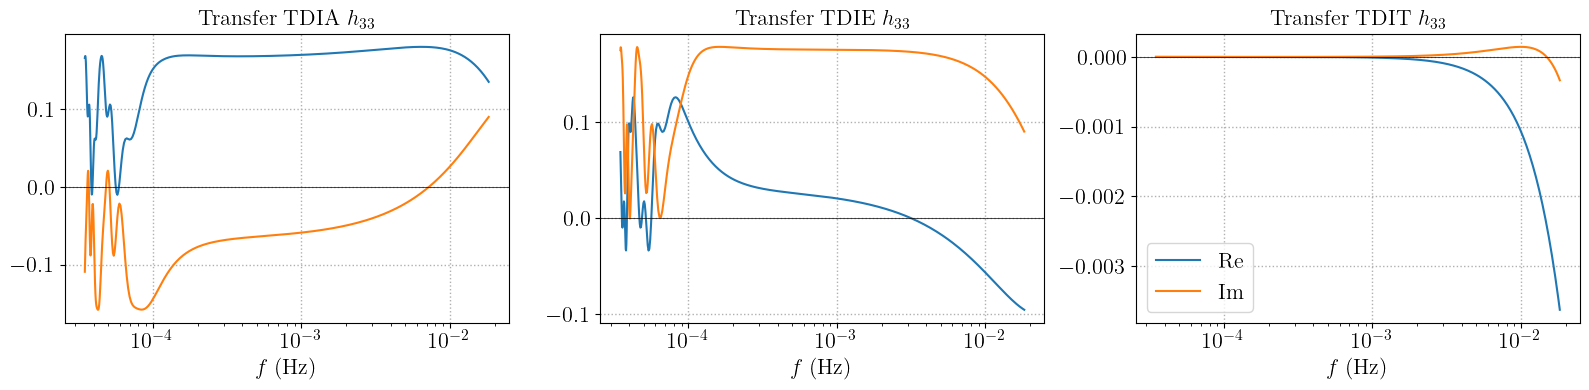

In [17]:
# Transfer functions, mode h33 (NOTE: rescaled by (6*pi*f*L/c))
titles = ['Transfer TDIA $h_{33}$', 'Transfer TDIE $h_{33}$', 'Transfer TDIT $h_{33}$']
lm = (3,3)

L = 2.5e9
rescaling = 1./(6*np.pi*wftdi[(3,3)]['freq']*L/pyconstants.C_SI)

fig, axs = plt.subplots(1,3, figsize=[16,4])
for i in range(3):
    transferstr = 'transferL' + str(i+1)
    axs[i].plot(wftdi[lm]['freq'], np.real(wftdi[lm][transferstr]) * rescaling, label='Re')
    axs[i].plot(wftdi[lm]['freq'], np.imag(wftdi[lm][transferstr]) * rescaling, label='Im')
    axs[i].set_xscale('log')
    axs[i].axhline(0., c='k', lw=0.5)
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_title(r'' + titles[i])
axs[2].legend(loc='lower left')
fig.tight_layout()

## Compute SNR

Recall that we the inner product intervening in the matched filter statistic and the likelihood is
$$ ( a | b ) = 4 \mathrm{Re} \int_{0}^{+\infty} df \; \frac{\tilde{a}^{*}(f)\tilde{b}(f)}{S_n(f)}$$

The SNR we are computing here is the optimal SNR, with $h$ standing for the signal; in our case, the signal is not a strain like in LVK, but is the TDI signal. We sum over the three independent (for equal-armlength) channels A,E,T:
$$ \mathrm{SNR}^2 = \sum_{\mathrm{chan}=A,E,T} (h_{\rm{chan}} | h_{\rm{chan}}) $$

### Basic SNR

In [18]:
# Compute the SNR (h|h) summed over 3 TDI channels
snrtools.lisa_mbhb_snr(params, **waveform_params)

980.5674891476933

In [19]:
%timeit snrtools.lisa_mbhb_snr(params, **waveform_params)

4 ms ± 378 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Cumulative SNR(t)

In [20]:
# Computing the cumulative SNR for 22 mode only, done at once

waveform_params_22 = copy.deepcopy(waveform_params)
waveform_params_22['modes'] = [(2,2)]

snrcumul = lisa.CumulSNRLISATDI_SMBH(params, **waveform_params_22)

mask = (snrcumul['tf'] < 0) & (snrcumul['SNRcumul'] > 0)

Text(0, 0.5, 'SNR(t)')

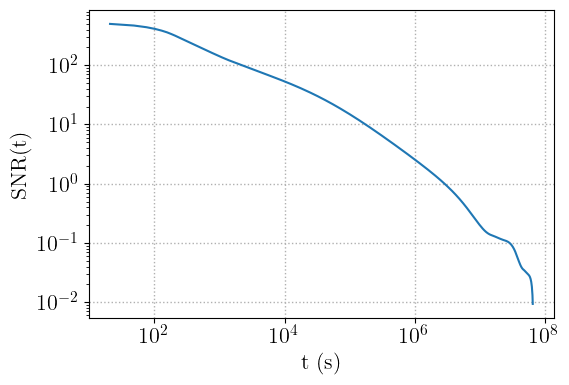

In [30]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.plot(-snrcumul['tf'][mask], snrcumul['SNRcumul'][mask])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r't (s)')
ax.set_ylabel(r'SNR(t)')

In [23]:
# Other functions

snrtools.lisa_SNRoft?

Signature: snrtools.lisa_SNRoft(times, params, pad_zero=False, **waveform_params)
Docstring: <no docstring>
File:      ~/miniconda3/envs/lal-py312/lib/python3.12/site-packages/lisabeta/lisa/snrtools.py
Type:      function

In [24]:
# Other functions

snrtools.lisa_tofSNR?

Signature: snrtools.lisa_tofSNR(SNR, params, **waveform_params)
Docstring: <no docstring>
File:      ~/miniconda3/envs/lal-py312/lib/python3.12/site-packages/lisabeta/lisa/snrtools.py
Type:      function

### SNR contribution of different HM

In [31]:
# More detailed interface: also stores SNR mode-by-mode (and some reconditioning of the waveform)
tdisignal = lisa.GenerateLISATDISignal_SMBH(params, **waveform_params)

In [32]:
# Total SNR (all channels, all modes)
tdisignal['SNR']

980.5674891476933

In [33]:
tdisignal.keys()

dict_keys(['SNR', 'SNR2modematrix', 'wftdi', 'tdi', 'weightedtdi'])

In [34]:
# Matrix of (lm,l'm') mode contributions to the SNR^2
tdisignal['SNR2modematrix']

{'modes': [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4)],
 'matrix': array([[ 7.43178659e+05, -1.37740532e+04,  6.81625943e+03,
         -3.07874367e+04, -4.19437902e+02],
        [-1.37740480e+04,  1.67179091e+03,  3.86674146e+02,
          8.40647342e+02,  2.53494608e+01],
        [ 6.81579719e+03,  3.86630864e+02,  2.43301867e+05,
         -1.78573974e+01,  3.70860832e+02],
        [-3.07874367e+04,  8.40631505e+02, -3.79139868e+01,
          2.39911299e+03, -6.02706394e+01],
        [-4.19425601e+02,  2.53458344e+01,  3.70172684e+02,
         -6.13179585e+01,  4.42219996e+04]])}

In [35]:
# SNR in individual modes
list(zip(tdisignal['SNR2modematrix']['modes'], np.sqrt(np.diag(tdisignal['SNR2modematrix']['matrix']))))

[((2, 2), 862.0781048195975),
 ((2, 1), 40.887539832854),
 ((3, 3), 493.25639099689135),
 ((3, 2), 48.98074104455781),
 ((4, 4), 210.2902745699225)]

/tmp/ipykernel_84546/3608236641.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+[str(lm) for lm in tdisignal['SNR2modematrix']['modes']])
/tmp/ipykernel_84546/3608236641.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+[str(lm) for lm in tdisignal['SNR2modematrix']['modes']])


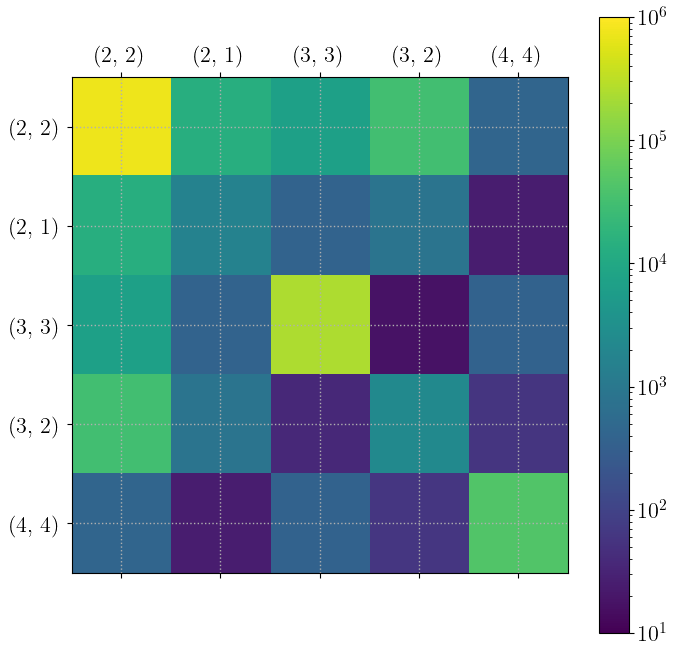

In [36]:
# Plotting the matrix of (h_lm | h_l'm') in log-scale (cross-terms can have either sign)

fig, ax = plt.subplots(1,1, figsize=[8,8])
cax = ax.matshow(np.abs(tdisignal['SNR2modematrix']['matrix']), interpolation='nearest', norm=mpl.colors.LogNorm(vmin=10., vmax=1e6))
ax.set_xticklabels(['']+[str(lm) for lm in tdisignal['SNR2modematrix']['modes']])
ax.set_yticklabels(['']+[str(lm) for lm in tdisignal['SNR2modematrix']['modes']])

fig.colorbar(cax)

## Fisher matrix

Recall that we the inner product intervening in the matched filter statistic and the likelihood is
$$ ( a | b ) = 4 \mathrm{Re} \int_{0}^{+\infty} df \; \frac{\tilde{a}^{*}(f)\tilde{b}(f)}{S_n(f)}$$

The likelihood in zero noise with a true signal $h_0$ is $\ln \mathcal{L} = - (h_0 -h |h_0 -h)/2$, becomes at leading order in parameter deviations $\Delta \theta^i$:
$$ \ln \mathcal{L}(\theta) = -\frac{1}{2} \Delta \theta^{j} \Delta \theta^{k} (\partial_{j} h | \partial_{k} h) + \mathcal{O} (\Delta \theta^{3})$$
This corresponds to a Gaussian approximation of the likelihood near its peak, and we can estimate the covariance as the inverse $\Gamma^{-1}$ of the Fisher matrix:
$$ \Gamma_{jk} = (\partial_{j} h | \partial_{k} h)$$
Waveform derivatives can be computed numerically by finite differences: (although some derivatives are analytical here, like $A$ and $\alpha$)
$$ \partial_{\theta^i} h = \frac{h(\theta^i + \varepsilon^i) - h(\theta^i - \varepsilon^i)}{2\varepsilon^i} $$
(abuse of notation, the other parameters are kept fixed). The steps $\varepsilon^i$ must be chosen within a certain range to achieve numerical stability of the derivative for each parameter.

In [176]:
list_params = ['M', 'q', 'chi1', 'chi2', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi']
params_complete = pytools.complete_mass_params(params)
params_complete = pytools.complete_spin_params(params_complete)

# Use frequency grid adjusted to inspiral phasing at low frequencies, logarithmic at high frequencies, with default number of points
freqs = ['nyquist_log', None]

# Do the computation in the L-frame
Lframe = True

steps = lisa_fisher.get_default_steps_smbh(params['M'])

steps

{'M': 4.999999999999999e-06,
 'Mchirp': 4.999999999999999e-06,
 'm1': 4.999999999999999e-06,
 'm2': 4.999999999999999e-06,
 'q': 0.00010000000000000009,
 'eta': 9.99999999999998e-06,
 'chi1': 9.99999999999998e-06,
 'chi2': 9.99999999999998e-06,
 'chip': 9.99999999999998e-06,
 'chim': 9.99999999999998e-06,
 'chis': 9.99999999999998e-06,
 'chia': 9.99999999999998e-06,
 'chiPN': 9.99999999999998e-06,
 'Deltat': 0.00010000000000000009,
 'dist': 9.99999999999998e-06,
 'inc': 0.00010000000000000009,
 'phi': 0.00010000000000000009,
 'lambda': 0.00010000000000000009,
 'beta': 0.00010000000000000009,
 'psi': 0.00010000000000000009}

In [177]:
%%time
fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=freqs, steps=steps, list_params=list_params, Lframe=Lframe, **waveform_params)

CPU times: user 1.16 s, sys: 124 ms, total: 1.28 s
Wall time: 1.3 s


In [178]:
fishercov.keys()

dict_keys(['params', 'list_params', 'fisher', 'cov', 'Lframe'])

In [179]:
# Fisher covariance matrix, 11*11
fishercov['list_params'], fishercov['cov']

(['M',
  'q',
  'chi1',
  'chi2',
  'Deltat',
  'dist',
  'inc',
  'phi',
  'lambda',
  'beta',
  'psi'],
 array([[ 8.71301188e+04,  1.75845625e-01,  4.27459115e-02,
         -2.70175265e-01, -4.40708493e+01, -1.97342748e+03,
         -3.08195550e-02,  3.66572124e-01,  2.83740749e-01,
         -4.60813530e-01,  1.33503816e-01],
        [ 1.75845625e-01,  4.47288350e-07,  9.08980038e-08,
         -7.08513204e-07, -1.00176142e-04, -5.27553752e-03,
         -8.78007637e-08,  7.53923831e-07,  7.92453048e-07,
         -1.20891892e-06,  3.94974861e-07],
        [ 4.27459115e-02,  9.08980038e-08,  2.62118394e-08,
         -1.76543038e-07, -2.39786886e-05, -1.32476130e-03,
         -1.58714006e-08,  1.95491480e-07,  1.59875635e-07,
         -3.03825503e-07,  6.18773802e-08],
        [-2.70175265e-01, -7.08513204e-07, -1.76543038e-07,
          1.51697501e-06,  1.78138519e-04,  1.14543365e-02,
          1.48789762e-07, -1.28181902e-06, -1.45176756e-06,
          2.58141792e-06, -6.12649990e-07]

In [180]:
# Fisher matrix for the given list of parameters, size n_dim*n_dim
fishercov['cov'].shape

(11, 11)

In [42]:
# sigma(M) / M
('M', np.sqrt(fishercov['cov'][0,0])/params_complete['M'])

('M', 0.0005132392150666697)

In [43]:
# sigma(q)
('q', np.sqrt(fishercov['cov'][1,1]))

('q', 0.005814327318626175)

In [44]:
# sigma(D) / D
('dist', np.sqrt(fishercov['cov'][5,5])/params_complete['dist'])

('dist', 0.014630358763420363)

In [45]:
# NOTE: the covariance is the matrix inverse of Fisher, correlations matter !
np.sqrt(fishercov['cov'][1,1]), 1./np.sqrt(fishercov['fisher'][1,1])

(0.005814327318626175, 0.0014198802852627237)

Formula to convert between Fisher covariance and sky area for a given probability level $p$:
$$ \mathcal{A} = -2\ln(1-p) \pi \cos \beta \sqrt{\mathrm{det} \Sigma_{\rm sky}}$$

In [46]:
# A helper function to compute the sky area at a certain probability level (or n-sigma level) from the Fisher covariance
# Formula: A = -2ln(1-p) * pi * cos(beta) * sqrt(det(cov_lambda_beta))
lisatools.sky_area_cov(fishercov, sq_deg=True, n_sigma=None, prob=0.90)

14.664330043803254

## Likelihood

Recall that we the inner product intervening in the matched filter statistic and the likelihood is
$$ ( a | b ) = 4 \mathrm{Re} \int_{0}^{+\infty} df \; \frac{\tilde{a}^{*}(f)\tilde{b}(f)}{S_n(f)}$$

The likelihood in zero noise with a true signal $h_0$ is:
$$ \ln \mathcal{L}(\theta) = - (h_0 - h(\theta) |h_0 - h(\theta))/2 $$

In the presence of noise $n$, the data stream is $d = h_0 + n$ and the likelihood becomes:
$$ \ln \mathcal{L}(\theta) = - (d - h(\theta) | d - h(\theta))/2 $$

In [47]:
template_params = params.copy()
template_params['q'] *= (1 + 1e-3)

In [48]:
%%time

# Fast heterodyne likelihood, based on residuals from a reference signal -- can also accomodate real data
# Has a startup cost were pre-computations occur
likelihood_residuals = lisa.LikelihoodLISASMBH_LinearResiduals(params, ngrid=128, **waveform_params)

CPU times: user 17.6 s, sys: 441 ms, total: 18.1 s
Wall time: 18.1 s


In [49]:
%%time
likelihood_residuals.lnL(template_params)

CPU times: user 1.9 ms, sys: 382 μs, total: 2.28 ms
Wall time: 2.27 ms


-3.8331906090905563

In [50]:
qvals = np.linspace(params['q'] - 1e-2, params['q'] + 1e-2)
likelihoodvals = np.zeros_like(qvals)
for i,q in enumerate(tqdm(qvals)):
    temp_params = params.copy()
    temp_params['q'] = q
    likelihoodvals[i] = likelihood_residuals.lnL(temp_params)

100%|█████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 701.04it/s]


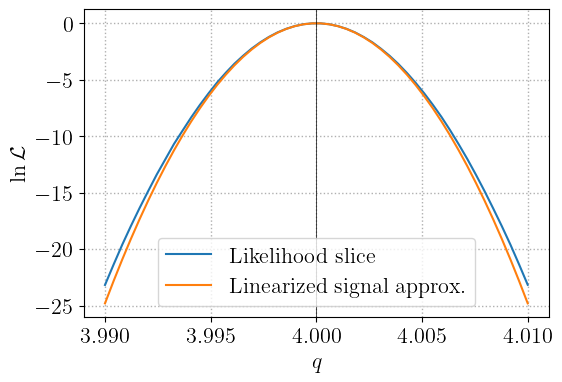

In [51]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.plot(qvals, likelihoodvals, label='Likelihood slice')
ax.plot(qvals, -1/2 * (qvals- params['q'])**2 * fishercov['fisher'][1,1], label='Linearized signal approx.')
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$\ln \mathcal{L}$')
ax.axvline(params['q'], c='k', lw=0.5)
ax.legend(loc='lower center')

# Interface for Bayesian parameter estimation

Sampler `ptemcee` available at `https://github.com/SylvainMarsat/ptemcee`, directly cloned locally as submodule if using git clone --recursive

## Interface and run parameters

Example `.json` submission file:
<code>{
  "source_params": {
    "M": 4e6,
    "q": 3.0,
    "chi1": 0.5,
    "chi2": 0.2,
    "Deltat": 0.0,
    "dist": 3.65943e+04,
    "inc": 1.0471975511965976,
    "phi": 1.2,
    "lambda": 0.8,
    "beta": 1.0471975511965976,
    "psi": 1.7,
    "Lframe": true
  },
  "waveform_params": {
    "minf": 1e-5,
    "maxf": 0.5,
    "t0": 0.0,
    "timetomerger_max": 1.0,
    "fend": null,
    "tmin": null,
    "tmax": null,
    "phiref": 0.0,
    "fref_for_phiref": 0.0,
    "tref": 0.0,
    "fref_for_tref": 0.0,
    "force_phiref_fref": true,
    "toffset": 0.0,
    "modes": null,
    "TDI": "TDIAET",
    "acc": 1e-4,
    "order_fresnel": 0,
    "approximant": "IMRPhenomHM",
    "LISAconst": "Proposal",
    "responseapprox": "full",
    "frozenLISA": false,
    "TDIrescaled": true,
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": false,
        "WDduration" : 0.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
  },
  "prior_params": {
    "list_params": ["M", "q", "chi1", "chi2", "Deltat", "dist", "inc", "phi", "lambda", "beta", "psi"],
    "infer_params": ["M", "q", "chi1", "chi2", "Deltat", "dist", "inc", "phi", "lambda", "beta", "psi"],
    "params_range": [[1e6, 1e7], [1., 10.], [-1.0, 1.0], [-1.0, 1.0], [-600.0, 600.0], [10e3, 100e3], [], [], [], [], []],
    "prior_type": ["uniform", "uniform", "uniform", "uniform", "uniform", "uniform", "sin", "uniform", "uniform", "cos", "uniform"],
    "wrap_params": null
  },
  "run_params": {
    "out_dir": "/Users/marsat/Projects/lisabeta/lisabeta/examples/ptemcee_smbh/",
    "out_name": "smbh_example",
    "sampler": "ptemcee",
    "sample_Lframe": true,
    "multimodal": true,
    "multimodal_pattern": "8modes",
    "p_jump": 0.5,
    "likelihood_method": "residuals",
    "likelihood_residuals_ngrid": 128,
    "skip_fisher": false,
    "init_method": "fisher",
    "init_scale_cov": 1.0,
    "zerolike": false,
    "n_temps": 10,
    "temp_max": null,
    "n_walkers": 64,
    "n_iter": 4000,
    "burn_in": 1000,
    "autocor_method": "autocor_new",
    "thin_samples": true,
    "upsample": 1,
    "seed": null,
    "print_info": true,
    "n_iter_info": 50,
    "output": true,
    "output_raw": true
  }
}
</code>

Run with `python <lisabeta>/lisabeta/inference/ptemcee_smbh.py example.json`

## Load results

In [52]:
subsdir = './example_pe/'
datadir = './example_pe/'

In [53]:
subfile = subsdir + 'mbhb_pe_example.json'
postfile = datadir + 'mbhb_pe_example.h5'

params_post = plotutils.load_params_posterior_lisa_smbh(subfile, postfile)

post_raw_file = datadir + 'mbhb_pe_example_raw.h5'

post_raw = {}
with h5py.File(post_raw_file, 'r') as hf:
    for p in params_post['prior_params']['infer_params']:
        post_raw[p] = hf[p][:]
    post_raw['lnL'] = hf['lnlike'][:]

In [54]:
params_post.keys()

dict_keys(['fishercov', 'injparams_SSBframe', 'injparams_Lframe', 'waveform_params', 'prior_params', 'run_params', 'post'])

In [55]:
params_post['prior_params']['infer_params']

['Mchirp',
 'q',
 'chip',
 'chim',
 'Deltat',
 'dist',
 'inc',
 'phi',
 'lambda',
 'beta',
 'psi']

In [56]:
# NOTE: here we cheated with initialization, 'init_method': 'fisher'. Appropriate for prospective science.

params_post['run_params']

{'out_dir': '/Users/marsat/Projects/tutorials/lisabeta_sky_tutorial/lisabeta_sky_tutorial/example_pe/',
 'out_name': 'mbhb_pe_example',
 'sampler': 'ptemcee',
 'sample_Lframe': True,
 'multimodal': True,
 'multimodal_pattern': '8modes',
 'p_jump': 0.5,
 'likelihood_method': 'residuals',
 'likelihood_residuals_ngrid': 128,
 'skip_fisher': False,
 'init_method': 'fisher',
 'init_scale_cov': 100.0,
 'zerolike': False,
 'n_temps': 4,
 'temp_max': 100.0,
 'n_walkers': 64,
 'n_iter': 4000,
 'burn_in': 1000,
 'autocor_method': 'autocor_new',
 'thin_samples': False,
 'seed': 0,
 'output': True,
 'output_raw': True}

In [57]:
params_post['post'].keys()

dict_keys(['Mchirp', 'q', 'chip', 'chim', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi', 'lnL', 'lnpost', 'Lframe', 'm1', 'm2', 'M', 'eta', 'chi1', 'chi2', 'chis', 'chia', 'chiPN'])

## Likelihood values

Text(0.5, 0, '$\\ln\\mathcal{L}$')

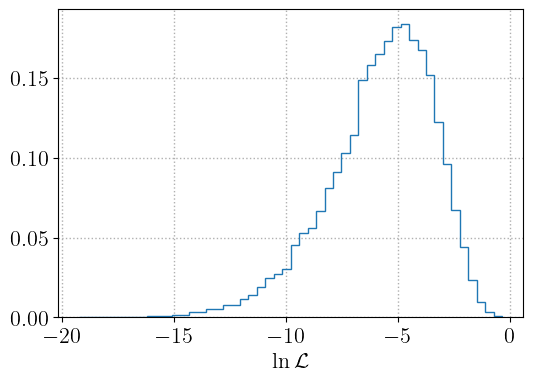

In [58]:
# We cheated with Fisher initialization, chains are good from the beginning !
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(params_post['post']['lnL'], histtype='step', density=True);
ax.set_xlabel(r'$\ln\mathcal{L}$')

In [59]:
def plot_postraw_lnL_trace(post_raw, rangey=None, title=''):

    nwalkers = post_raw['lnL'].shape[0]
    nsteps = post_raw['lnL'].shape[1]

    #Threshold to eliminate the -1e99 values that mess up plots
    masks = [post_raw['lnL'][i] > -1e12 for i in range(nwalkers)]
    fig, ax = plt.subplots(1,1, figsize=[16,4])
    plotutils.llogplot(ax, *[[np.arange(nsteps)[masks[i]], -post_raw['lnL'][i][masks[i]]] for i in range(nwalkers)], rangey=rangey)

    ax.set_xlabel(r'$\mathrm{Steps}$')
    ax.set_ylabel(r'$-\ln \mathcal{L}$')
    ax.set_title(title)

    return fig

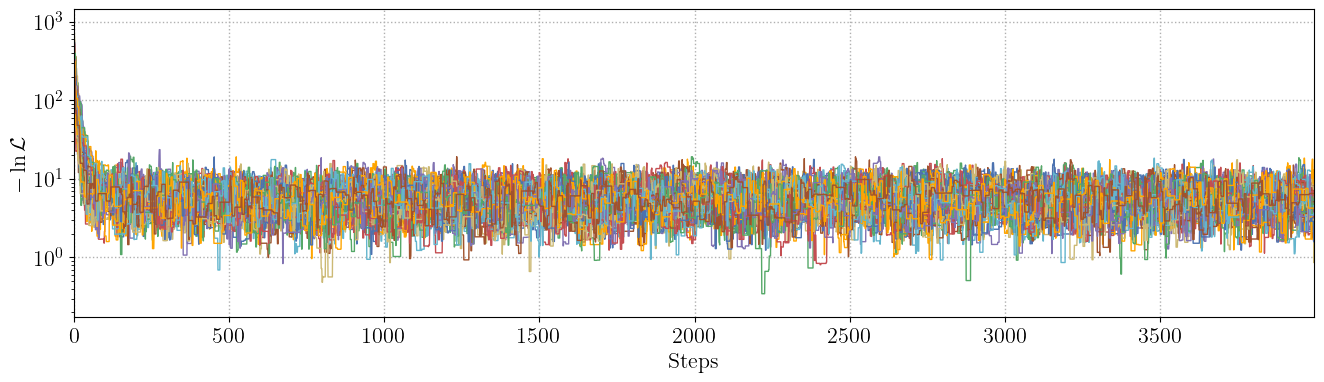

<Figure size 800x400 with 0 Axes>

In [60]:
# We cheated with Fisher initialization, chains are good from the beginning !
plot_postraw_lnL_trace(post_raw);

In [61]:
# Plot from a different system and setting, initializing from prior

# WARNING: burn-in can be hard for loud signals, can get stuck in secondary maxima for a long time (PT helps)

# plot_postraw_lnL_trace(post_raw);

## Posterior

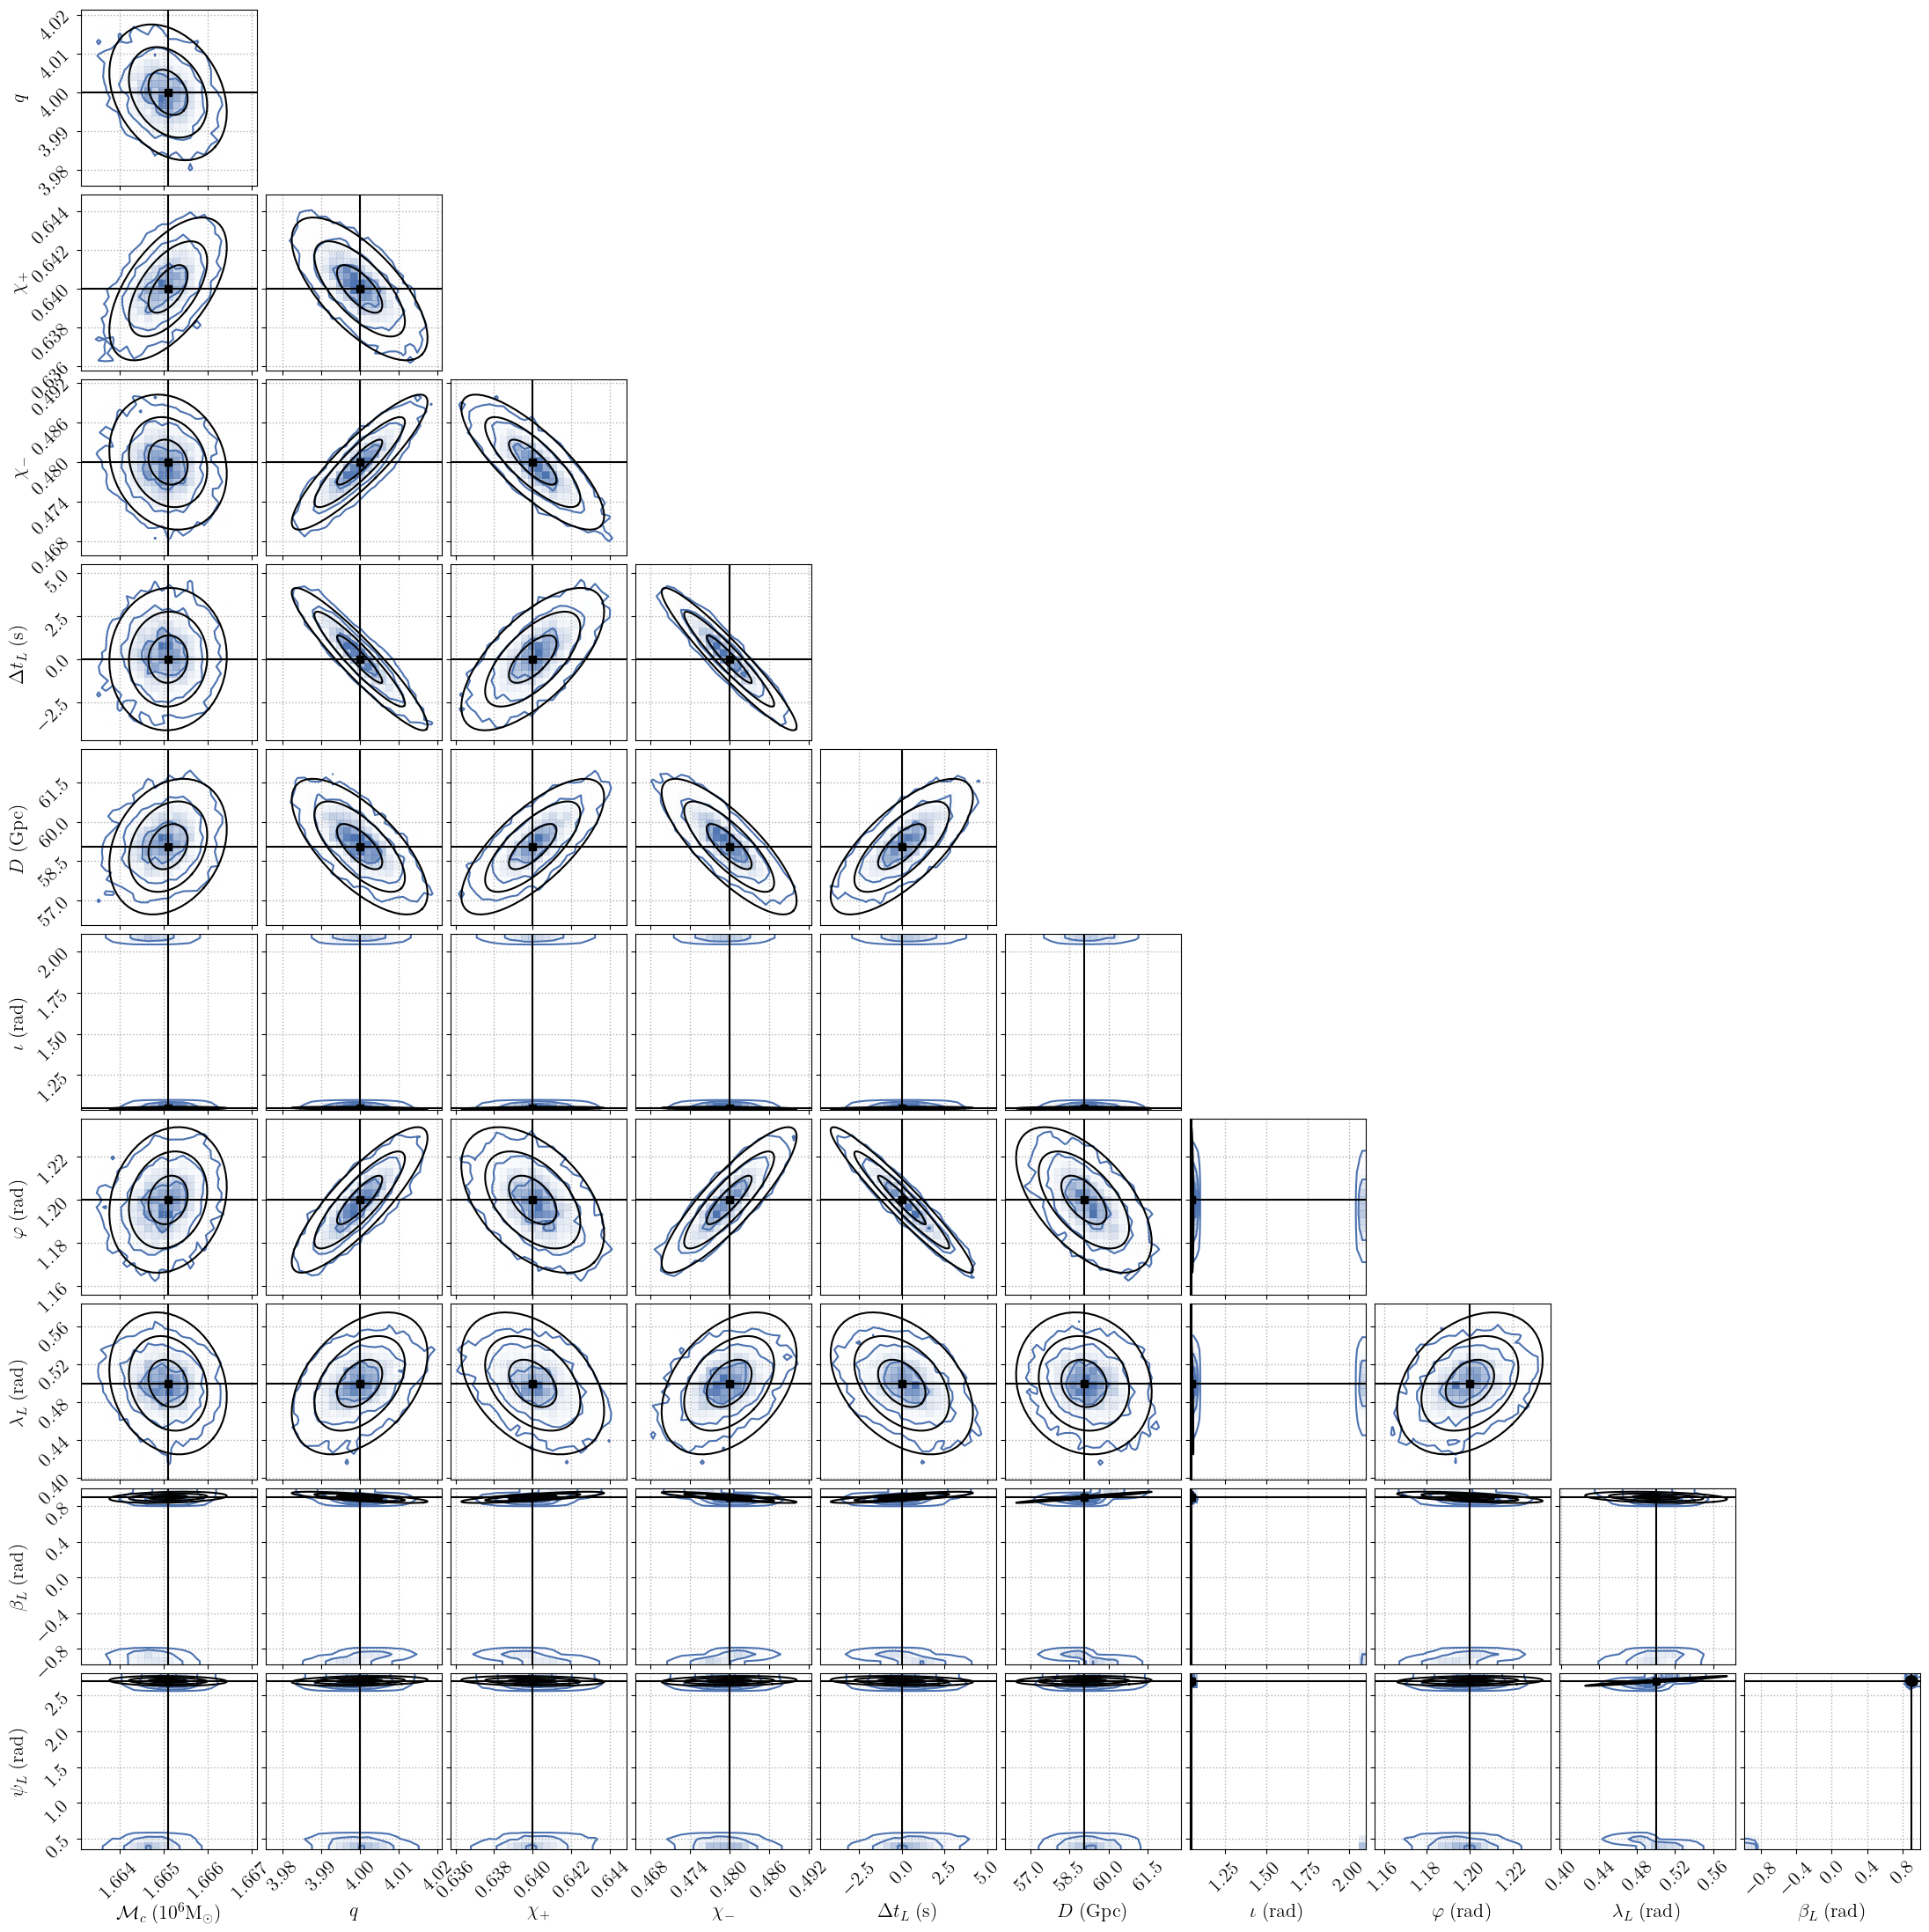

In [62]:
fig = plotutils.corner_plot(params_post['injparams_Lframe'], params_post['post'], output=False, histograms=True, fisher=True, fishercov=params_post['fishercov'], params=['Mchirp', 'q', 'chip', 'chim', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi'], Lframe=True, color=plotutils.plotpalette[0], cov_color='k', show_truths=True, truth_color='k', bins=25, show_histograms=False, plot_datapoints=False);

# Noise and choice of TDI variables

## Instrumental noise and confusion background interface

In [63]:
# Format for the noise
waveform_params['LISAnoise']

{'InstrumentalNoise': 'SciRDv1',
 'WDbackground': True,
 'WDduration': 4.0,
 'lowf_add_pm_noise_f0': 0.0,
 'lowf_add_pm_noise_alpha': 2.0}

In [64]:
# Evaluate noise with different WD backgrounds (different LISA durations)

freqs = np.geomspace(1e-6, 1., 10000)

waveform_params_WD = {}
for duration in [1,4,10]:
    waveform_params_WD[duration] = copy.deepcopy(waveform_params)
    waveform_params_WD[duration]['LISAnoise']['WDbackground'] = True
    waveform_params_WD[duration]['LISAnoise']['WDduration'] = duration
waveform_params_WD[0] = copy.deepcopy(waveform_params)
waveform_params_WD[0]['LISAnoise']['WDbackground'] = False

psd_WD = {}
for k in waveform_params_WD.keys():
    psd_WD[k] = pyLISAnoise.evaluate_AET_psd(freqs, TDIT=True, **waveform_params_WD[k])

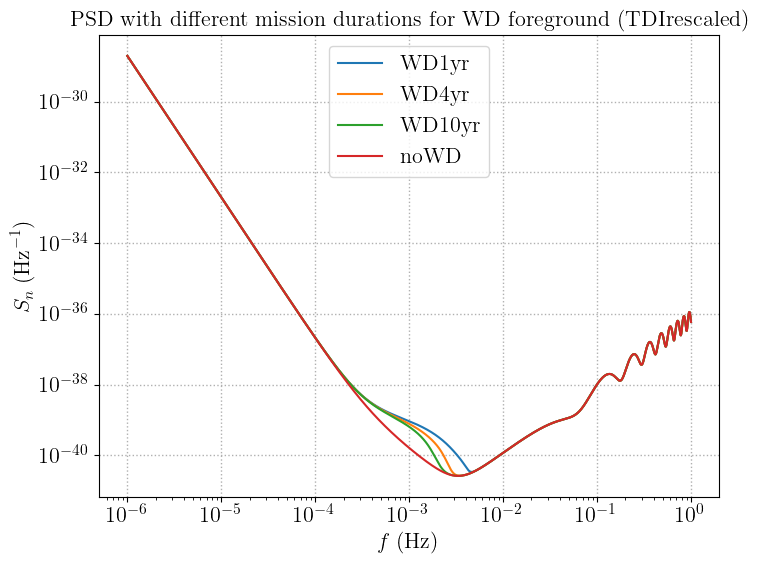

In [65]:
fig, ax = plt.subplots(1,1, figsize=[8,6])
for k in waveform_params_WD.keys():
    label='WD' + str(k) + 'yr'
    if k==0:
        label = 'noWD'
    ax.plot(freqs, psd_WD[k]['TDIA'], label=label)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$f \; (\mathrm{Hz})$')
ax.set_ylabel(r'$S_n \; (\mathrm{Hz}^{-1})$')
ax.set_title(r'PSD with different mission durations for WD foreground (TDIrescaled)')
ax.legend(loc='upper center')

In [66]:
# Evaluate noise for different TDI variables

freqs = np.geomspace(1e-6, 1., 10000)

waveform_params_TDI = {}
waveform_params_TDI['TDIrescaled'] = copy.deepcopy(waveform_params)
waveform_params_TDI['TDI1'] = copy.deepcopy(waveform_params)
waveform_params_TDI['TDI2'] = copy.deepcopy(waveform_params)

waveform_params_TDI['TDIrescaled']['TDIrescaled'] = True
waveform_params_TDI['TDI1']['TDIrescaled'] = False
waveform_params_TDI['TDI2']['TDIrescaled'] = False

waveform_params_TDI['TDIrescaled']['TDI'] = 'TDIAET'
waveform_params_TDI['TDI1']['TDI'] = 'TDIAET'
waveform_params_TDI['TDI2']['TDI'] = 'TDI2AET'

psd_TDI = {}
for k in waveform_params_TDI.keys():
    psd_TDI[k] = pyLISAnoise.evaluate_AET_psd(freqs, TDIT=True, **waveform_params_TDI[k])

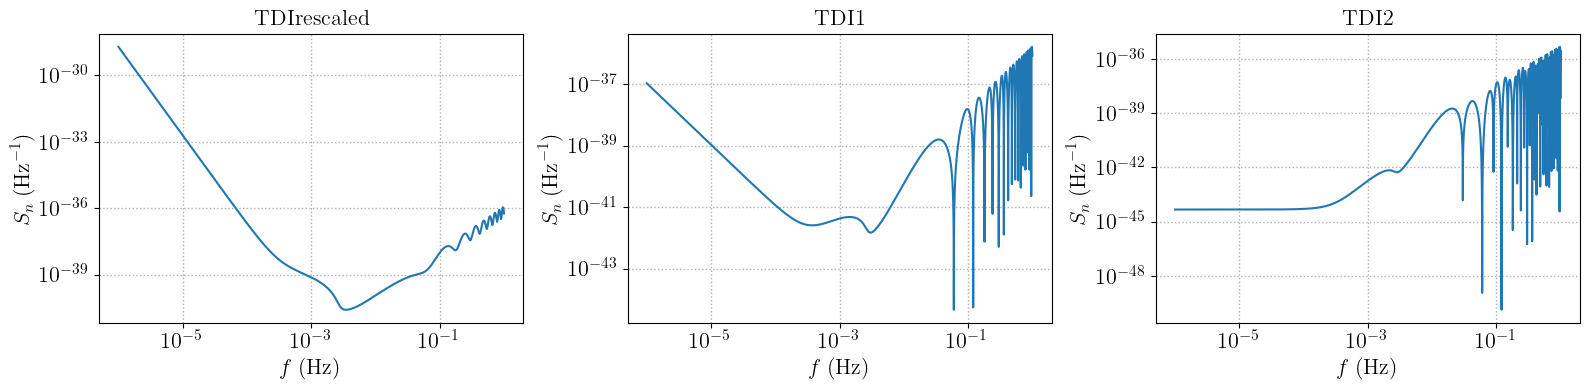

In [67]:
fig, axs = plt.subplots(1,3, figsize=[16,4])
for i,k in enumerate(waveform_params_TDI.keys()):
    axs[i].plot(freqs, psd_TDI[k]['TDIA'], label=k)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_ylabel(r'$S_n \; (\mathrm{Hz}^{-1})$')
    axs[i].set_title(k)
fig.tight_layout()

In [68]:
# We can also use numerical data for the noise, which will be linearly interpolated on the needed frequencies

In [69]:
# Compute the SNR (h|h) summed over 3 TDI channels
snrtools.lisa_mbhb_snr(params, **waveform_params)

980.5674891476933

In [70]:
waveform_params_numnoise = copy.deepcopy(waveform_params)
waveform_params_numnoise['LISAnoise'] = np.array([psd_WD[4]['freq'], psd_WD[4]['TDIA'], psd_WD[4]['TDIE'], psd_WD[4]['TDIT']]).T

In [71]:
# Compute the SNR (h|h) summed over 3 TDI channels
snrtools.lisa_mbhb_snr(params, **waveform_params_numnoise)

980.567489149763

## Different TDI generations for the signal

In [72]:
freqs_wf = np.geomspace(1e-5, 8e-2, 10000)

tdidata_TDI = {}
for k in waveform_params_TDI.keys():
    tdidata_TDI[k] = lisa.smbh_generate_AET_signal(params, freqs_wf, **waveform_params_TDI[k], output_modes=False)

In [73]:
tdidata_TDI['TDIrescaled'].keys()

dict_keys(['freq', 'TDIA', 'TDIE', 'TDIT'])

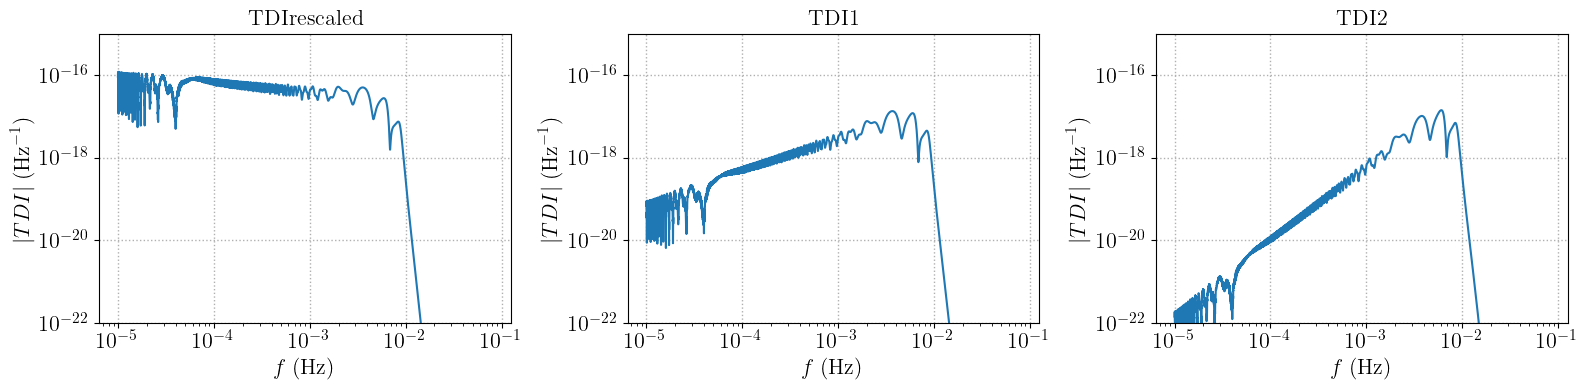

In [74]:
fig, axs = plt.subplots(1,3, figsize=[16,4])
for i,k in enumerate(waveform_params_TDI.keys()):
    axs[i].plot(freqs_wf, np.abs(tdidata_TDI[k]['TDIA']), label=k)
    axs[i].set_ylim(1e-22, 1e-15)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_ylabel(r'$|TDI| \; (\mathrm{Hz}^{-1})$')
    axs[i].set_title(k)
fig.tight_layout()

# Numerics: frequency arrays, overlaps

## Signal representation: dense or sparse frequency array ?

### Waveform and response

In [75]:
# This is the sparse signal representation chosen in FD: enough to spline-interpolate amplitudes, phases, and TDI transfer functions
wftdi = lisa.GenerateLISATDI_SMBH(params, **waveform_params)
wftdi[(2,2)]['freq'].shape[0]

308

In [76]:
# Exposing the function determining this sparse sampling
fLow = wftdi[(2,2)]['freq'][0]
fHigh = wftdi[(2,2)]['freq'][-1]

pytools.FrequencyGrid(fLow, fHigh, params['M'], params['q'], acc=1e-4, DeltalnMf_max=0.025).get_freq().shape

(308,)

Text(0.5, 1.0, 'Waveform sparse frequency spacing')

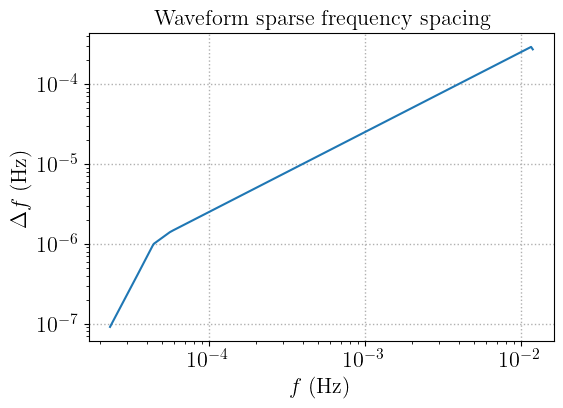

In [77]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.plot(wftdi[(2,2)]['freq'][:-1], np.diff(wftdi[(2,2)]['freq']))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$f \; (\mathrm{Hz})$')
ax.set_ylabel(r'$\Delta f \; (\mathrm{Hz})$')
ax.set_title(r'Waveform sparse frequency spacing')

### Frequency grids for the Fisher matrix

In [78]:
# Fisher matrix computation: we use much denser grids to compute the Fisher elements (dh | dh)
list_params = ['M', 'q', 'chi1', 'chi2', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi']

In [79]:
waveform_params['modes']

In [80]:
%%time
# Fine spacing, but trying to have a finer sampling at the beginning and coarser at the end -- recommended
fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=['nyquist_log', None], steps=None, list_params=list_params, Lframe=True, **waveform_params)

CPU times: user 788 ms, sys: 78.9 ms, total: 867 ms
Wall time: 868 ms


In [81]:
%%time
# Log-spacing, controlling the total number of points, good enough for short signals -- for quick computations
fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=['log', 10000], steps=None, list_params=list_params, Lframe=True, **waveform_params)

CPU times: user 78.4 ms, sys: 9.76 ms, total: 88.1 ms
Wall time: 87.1 ms


In [82]:
%%time
# Linear-spacing, as we would have in a dataset given by an FFT -- safe but very slow for long signals
fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=['linear', None], steps=None, list_params=list_params, Lframe=True, **waveform_params)

CPU times: user 23.5 s, sys: 4.44 s, total: 28 s
Wall time: 28 s


### Different likelihoods

In [83]:
template_params = params.copy()
template_params['q'] *= (1 + 1e-3)

In [84]:
%%time
# Historic 0-noise likelihood, moderately fast
likelihood = lisa.LikelihoodLISASMBH(params, **waveform_params)

CPU times: user 5.87 ms, sys: 565 μs, total: 6.44 ms
Wall time: 5.88 ms


In [85]:
%%time

# Faster likelihood, based on residuals from a reference signal -- can also accomodate real data
# Has a startup cost were pre-computations occur
likelihood_residuals = lisa.LikelihoodLISASMBH_LinearResiduals(params, ngrid=128, **waveform_params)

CPU times: user 12 s, sys: 335 ms, total: 12.3 s
Wall time: 12.4 s


In [86]:
%%time
likelihood.lnL(template_params)

CPU times: user 7.97 ms, sys: 558 μs, total: 8.52 ms
Wall time: 7.97 ms


-3.842434602614958

In [87]:
%%time
likelihood_residuals.lnL(template_params)

CPU times: user 2.04 ms, sys: 331 μs, total: 2.37 ms
Wall time: 2.08 ms


-3.8331906090905563

In [88]:
%%time

# Slower likelihood, based on basic trapeze integration of overlaps with a dense array of frequencies -- handles naturally real data
likelihood_data = lisa.LikelihoodLISASMBH_Data(params, data=tdidata_TDI['TDIrescaled'], data_noise_only=False, **waveform_params)

CPU times: user 15.1 ms, sys: 7.56 ms, total: 22.6 ms
Wall time: 21.5 ms


In [89]:
%%time
likelihood_data.lnL(template_params)

CPU times: user 12.3 ms, sys: 3.09 ms, total: 15.4 ms
Wall time: 14.3 ms


-3.8859499559156183

## Fisher matrix: check the steps for numerical derivatives !

In [90]:
# Default settings: (slightly) mass-dependent numerical steps for all parameters
# WARNING: you should always check the sensitivity of the Fisher results to the choice of these numerical steps for the derivatives !
list_p = ['M', 'q', 'chi1', 'inc']

Mvals = np.geomspace(1e3, 1e8, 20)
stepvals = {}
for p in list_p:
    stepvals[p] = np.zeros_like(Mvals)
for i,M in enumerate(Mvals):
    steps = lisa_fisher.get_default_steps_smbh(M)
    for p in list_p:
        stepvals[p][i] = steps[p]

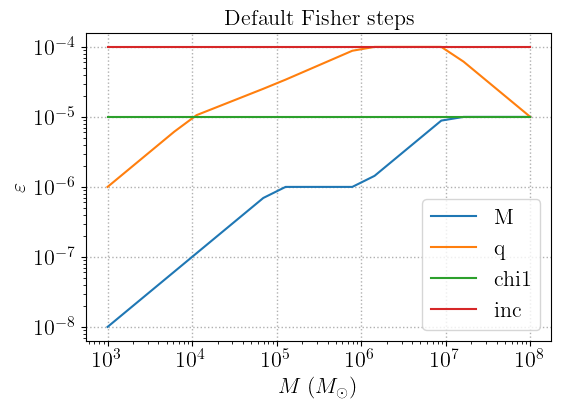

In [91]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
for p in list_p:
    ax.plot(Mvals, stepvals[p], label=p)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M \; (M_\odot)$')
ax.set_ylabel(r'$\varepsilon$')
ax.set_title(r'Default Fisher steps')
ax.legend(loc='lower right')

In [92]:
# For masses and distance, steps are relative by default
lisa_fisher.dict_params_fractional

{'M': True,
 'Mchirp': True,
 'm1': True,
 'm2': True,
 'q': False,
 'eta': False,
 'chi1': False,
 'chi2': False,
 'chip': False,
 'chim': False,
 'chis': False,
 'chia': False,
 'chiPN': False,
 'Deltat': False,
 'fstart': True,
 'dist': True,
 'inc': False,
 'phi': False,
 'lambda': False,
 'beta': False,
 'psi': False,
 'f0': True,
 'fdot0': False,
 'amp': True}

# Time-domain interface

In [93]:
# With this interface, we set up carefully the time interval using tmin, tmax, choosing the total length to be a power of 2
dt = 5.
t0_s = 30 * 86400.
N = 16384
N_after = int(np.rint(4*3600. / dt))
tmin_s = t0_s - ((N - N_after)*dt)
tmax_s = t0_s + ((N_after-1)*dt)

tmin = tmin_s / pyconstants.YRSID_SI
tmax = tmax_s / pyconstants.YRSID_SI
t0 = t0_s / pyconstants.YRSID_SI

In [94]:
len(np.arange(tmin_s, tmax_s+dt, dt)), N, N_after, (t0_s - tmin_s)

(16384, 16384, 2880, 67520.0)

In [95]:
waveform_params_td = copy.deepcopy(waveform_params)
waveform_params_td['dt'] = dt
waveform_params_td['t0'] = t0
waveform_params_td['tmin'] = tmin
waveform_params_td['tmax'] = tmax

In [97]:
Mlist = ['1e5', '1e6', '1e7']

tdi_td = {}
for Mstr in Mlist:
    params_M = params.copy()
    params_M['M'] = float(Mstr)
    tdi_td[Mstr] = lisa.GenerateLISATDI_TD_IFFT_SMBH(params_M, whitening=True, output_modes=True, **waveform_params_td)
tdi_td['1e6'].keys()

dict_keys(['TDIA', (2, 2), (2, 1), (3, 3), (3, 2), (4, 4), 't', 'modes', 'freq_bounds'])

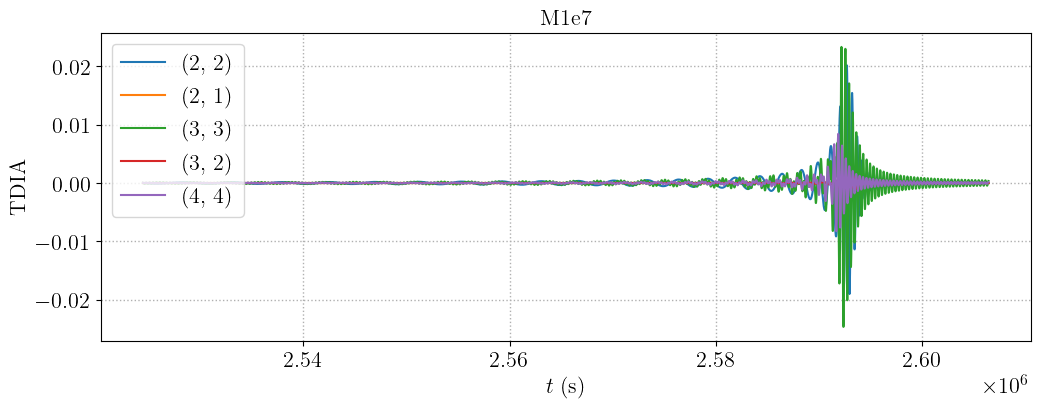

In [102]:
Mstr = '1e7'

fig, ax = plt.subplots(1,1, figsize=[12,4])
for lm in tdi_td[Mstr]['modes']:
    ax.plot(tdi_td[Mstr]['t'], tdi_td[Mstr][lm]['TDIA'], label=str(lm))
ax.set_xlabel(r'$t \; (\mathrm{s})$')
ax.set_ylabel(r'TDIA')
ax.set_title(r'M'+Mstr)
ax.legend(loc='upper left')

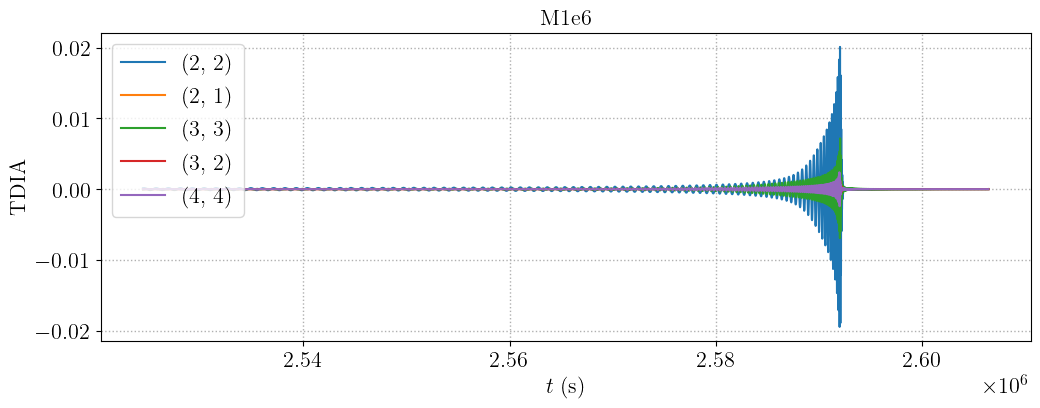

In [103]:
Mstr = '1e6'

fig, ax = plt.subplots(1,1, figsize=[12,4])
for lm in tdi_td[Mstr]['modes']:
    ax.plot(tdi_td[Mstr]['t'], tdi_td[Mstr][lm]['TDIA'], label=str(lm))
ax.set_xlabel(r'$t \; (\mathrm{s})$')
ax.set_ylabel(r'TDIA')
ax.set_title(r'M'+Mstr)
ax.legend(loc='upper left')

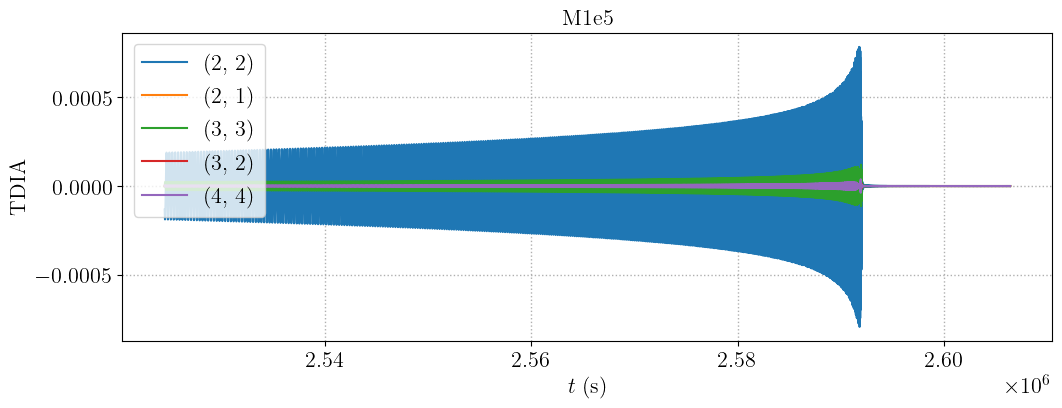

In [104]:
Mstr = '1e5'

fig, ax = plt.subplots(1,1, figsize=[12,4])
for lm in tdi_td[Mstr]['modes']:
    ax.plot(tdi_td[Mstr]['t'], tdi_td[Mstr][lm]['TDIA'], label=str(lm))
ax.set_xlabel(r'$t \; (\mathrm{s})$')
ax.set_ylabel(r'TDIA')
ax.set_title(r'M'+Mstr)
ax.legend(loc='upper left')

# Fisher sky localization

## Setting parameters

In [105]:
params = {
    # Total *redshifted* mass M=m1+m2, solar masses
    "M": 5e6,
    # Mass ratio q=m1/m2
    "q": 4.0,
    # Dimensionless spin component 1 along orbital momentum
    "chi1": 0.7,
    # Dimensionless spin component 2 along orbital momentum
    "chi2": 0.4,
    # Time shift of coalescence, s -- coalescence is at t0*yr + Deltat*s, t0 in waveform_params
    "Deltat": 0.0,
    # Luminosity distance, Mpc
    "dist": cosmo.luminosity_distance(1).value,
    # Inclination, observer's colatitude in source-frame
    "inc": 1.0471975511965976,
    # Phase, observer's longitude in source-frame
    "phi": 1.2,
    # Longitude in the sky
    "lambda": 0.5,
    # Latitude in the sky
    "beta": 0.9,
    # Polarization angle
    "psi": 2.7,
    # Flag indicating whether angles and Deltat pertain to the L-frame or SSB-frame
    "Lframe": True
  }

In [106]:
# Parameters for the waveform generation and other options

waveform_params = {
    # Frequency range
    "minf": 1e-5,
    "maxf": 0.5,
    # Reference epoch of coalescence, yr -- coalescence is at t0*yr + Deltat*s, Deltat in params
    "t0": 0.0,
    # Always cut signals timetomerger_max*yr before merger -- to avoid needlessly long signals using minf
    "timetomerger_max": 2.0,
    # Option to cut the signal pre-merger -- must be in L-frame
    "DeltatL_cut": None,
    # Further options to cut signals
    "fstart22": None,
    "fend22": None,
    "tmin": None,
    "tmax": None,
    # TDI channels to generate
    "TDI": "TDIAET",
    # Internal accuracy params
    "order_fresnel": 0,
    # Waveform approximant and set of harmonics to use
    "approximant": "IMRPhenomXHM",
    "modes": None,
    # LISA response options
    "LISAconst": "Proposal",
    "responseapprox": "full",
    "frozenLISA": False,
    "TDIrescaled": True,
    # Noise options -- can also be given as a numpy array for interpolation
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": True,
        "WDduration" : 4.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
  }

In [107]:
list_params = ['Mchirp', 'q', 'chip', 'chim', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi']

# Use frequency grid adjusted to inspiral phasing at low frequencies, logarithmic at high frequencies, with default number of points
freqs = ['nyquist_log', None]

# Do the computation in the L-frame
Lframe = True

steps = lisa_fisher.get_default_steps_smbh(params['M'])

fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=freqs, steps=steps, list_params=list_params, Lframe=Lframe, **waveform_params)

In [108]:
lisatools.sky_area_cov(fishercov, sq_deg=True, n_sigma=None, prob=0.90)

0.19396840122278902

In [109]:
lisatools.error_volume_cov(fishercov, sq_deg=True, n_sigma=None, prob=0.90)

1.3096912645603398

## Variation with M

In [110]:
Mvals = np.geomspace(1e4, 1e8, 100)
zref = 1.

In [111]:
skyarea90_vals = np.zeros_like(Mvals)
for iM,M in enumerate(tqdm(Mvals)):
    params_M = copy.deepcopy(params)
    params_M['M'] = M
    params_M['dist'] = cosmo.luminosity_distance(zref).value
    fishercov = lisa_fisher.fisher_covariance_smbh(params_M, freqs=['log', 10000], steps=None, list_params=list_params, Lframe=Lframe, **waveform_params)
    skyarea90_vals[iM] = lisatools.sky_area_cov(fishercov, sq_deg=True, n_sigma=None, prob=0.90)

100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.05it/s]


Text(0.5, 1.0, 'Fisher sky area at 90\\% level (one example system)')

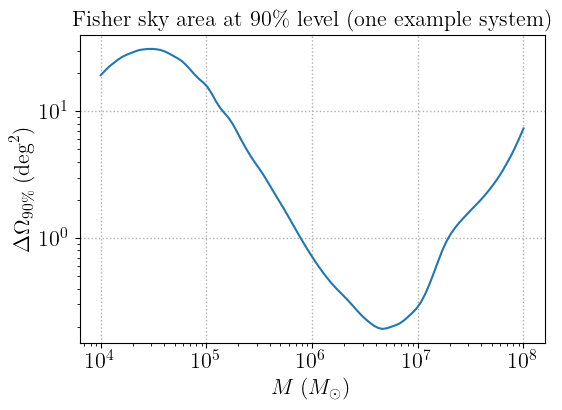

In [112]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.plot(Mvals, skyarea90_vals)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M \; (M_\odot)$')
ax.set_ylabel(r'$\Delta\Omega_{90\%} \; (\mathrm{deg}^2)$')
ax.set_title(r'Fisher sky area at 90\% level (one example system)')
# ax.legend(loc='lower right')

In [113]:
# Here we rescale the Fisher error: for a given Mz, it scales as dL^2

skyarea90_loglogspline_zref = pytools.spline(np.log(Mvals), np.log(skyarea90_vals))

def skyarea_interp(Msource, z):
    M = Msource * (1+z)
    if M > Mvals[-1] or M < Mvals[0]:
        return np.nan
    DLfactor = cosmo.luminosity_distance(z).value / cosmo.luminosity_distance(zref).value
    return np.exp(skyarea90_loglogspline_zref(np.log(M))) * DLfactor**2

In [114]:
zref = 1.

nb_z_mesh = 100
nb_Msource_mesh = 200
zvals = np.linspace(0.05, 10., nb_z_mesh)
Msourcevals = pytools.logspace(5e4, 5e7, nb_Msource_mesh)
Msource_mesh, z_mesh = np.meshgrid(Msourcevals, zvals)

In [115]:
skyarea_mesh = np.zeros((nb_z_mesh, nb_Msource_mesh))
for j in range(nb_Msource_mesh):
    for i in range(nb_z_mesh):
        Msource = Msource_mesh[i,j]
        z = z_mesh[i,j]
        skyarea_mesh[i,j] = skyarea_interp(Msource, z)

/tmp/ipykernel_84546/3463996485.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cs = ax.contourf(Msource_mesh, z_mesh, skyarea_mesh, levels, norm=mpl.colors.LogNorm(), extend='max', cmap=mpl.cm.get_cmap('viridis_r'))
/tmp/ipykernel_84546/3463996485.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


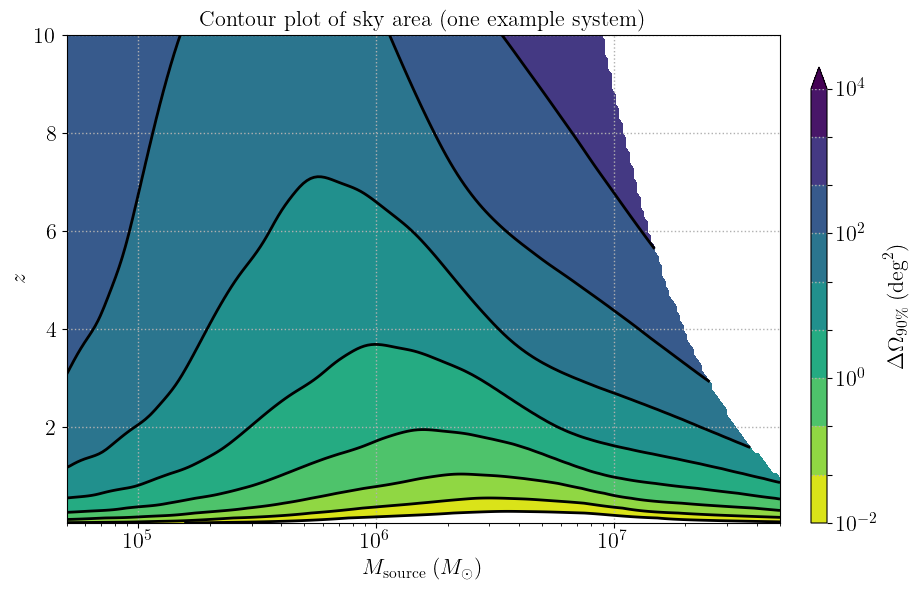

In [116]:
levels = 10**np.linspace(-2, 4, 10)

fig, ax = plt.subplots(1,1, figsize=[8,6])

cs = ax.contourf(Msource_mesh, z_mesh, skyarea_mesh, levels, norm=mpl.colors.LogNorm(), extend='max', cmap=mpl.cm.get_cmap('viridis_r'))
ax.contour(Msource_mesh, z_mesh, skyarea_mesh, levels, colors='k', linewidths=2)
cb_ax = fig.add_axes([1.02, 0.12, 0.02, 0.76]) # left, bottom, width, height
cbar = fig.colorbar(cs, cax=cb_ax, ticks=levels)
cbar.ax.set_ylabel(r'$\Delta \Omega_{90\%} \; (\mathrm{deg}^2)$', fontsize=16)
plt.subplots_adjust(wspace=0.15)
ax.set_xscale('log')
ax.set_xlabel(r'$M_{\rm source} \; (M_{\odot})$')
ax.set_ylabel(r'$z$')
ax.set_title(r'Contour plot of sky area (one example system)')
    
fig.tight_layout()

## Trend in (inc, betaL)

In [117]:
fishercov_fast = lisa_fisher.fisher_covariance_smbh(params, freqs=['log', 10000], steps=steps, list_params=list_params, Lframe=Lframe, **waveform_params)

In [118]:
%time fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=freqs, steps=steps, list_params=list_params, Lframe=Lframe, **waveform_params)
%time fishercov_fast = lisa_fisher.fisher_covariance_smbh(params, freqs=['log', 10000], steps=steps, list_params=list_params, Lframe=Lframe, **waveform_params)

CPU times: user 850 ms, sys: 82.2 ms, total: 932 ms
Wall time: 933 ms
CPU times: user 71.5 ms, sys: 7.94 ms, total: 79.5 ms
Wall time: 79.5 ms


In [119]:
# Here we compute the sky area over a mesh of (inc, betaL)
nb_inc_mesh = 10
nb_betaL_mesh = 10
eps = 1e-3
incvals = np.linspace(0. + eps, np.pi - eps, nb_inc_mesh)
betaLvals = np.linspace(-np.pi/2 + eps, np.pi/2 - eps, nb_betaL_mesh)
inc_mesh, betaL_mesh = np.meshgrid(incvals, betaLvals)

In [120]:
snr_mesh = np.zeros((nb_betaL_mesh, nb_inc_mesh))
skyarea90_mesh = np.zeros((nb_betaL_mesh, nb_inc_mesh))
sigma_dL_rel_mesh = np.zeros((nb_betaL_mesh, nb_inc_mesh))
for j in tqdm(range(nb_inc_mesh)):
    for i in range(nb_betaL_mesh):
        inc = inc_mesh[i,j]
        betaL = betaL_mesh[i,j]
        params_temp = params.copy()
        params_temp['inc'] = inc
        params_temp['beta'] = betaL
        tdisignal = lisa.GenerateLISATDISignal_SMBH(params_temp, **waveform_params)
        snr = tdisignal['SNR']
        fishercov = lisa_fisher.fisher_covariance_smbh(params_temp, freqs=['log', 10000], Lframe=True, **waveform_params)
        idist = fishercov['list_params'].index('dist')
        sigma_dL_rel = np.sqrt(fishercov['cov'][idist,idist]) / params['dist']
        skyarea90 = lisatools.sky_area_cov(fishercov, sq_deg=True, prob=0.90)
        snr_mesh[i,j] = snr
        skyarea90_mesh[i,j] = skyarea90
        sigma_dL_rel_mesh[i,j] = sigma_dL_rel

100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


In [121]:
np.min(snr_mesh), np.max(snr_mesh)

(2538.2773344278635, 18051.57867787921)

/tmp/ipykernel_84546/1563379574.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cs = ax.contourf(inc_mesh, betaL_mesh, snr_mesh, levels_snr, extend='both', cmap=mpl.cm.get_cmap('viridis'))
/tmp/ipykernel_84546/1563379574.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


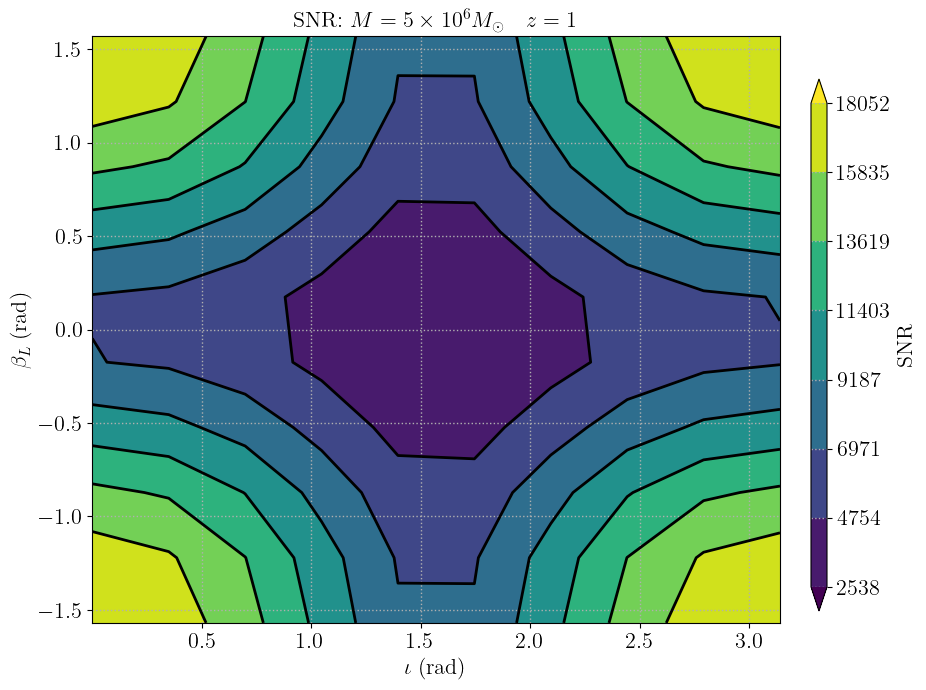

In [122]:
levels_snr = np.linspace(np.min(snr_mesh), np.max(snr_mesh), 8)

fig, ax = plt.subplots(1,1, figsize=[8,7])

cs = ax.contourf(inc_mesh, betaL_mesh, snr_mesh, levels_snr, extend='both', cmap=mpl.cm.get_cmap('viridis'))
ax.contour(inc_mesh, betaL_mesh, snr_mesh, levels_snr, colors='k', linewidths=2)
cb_ax = fig.add_axes([1.02, 0.12, 0.02, 0.76]) # left, bottom, width, height
cbar = fig.colorbar(cs, cax=cb_ax, ticks=levels_snr)
cbar.ax.set_ylabel(r'$\mathrm{SNR}$', fontsize=16)
plt.subplots_adjust(wspace=0.15)
ax.set_xlabel(r'$\iota \; (\mathrm{rad})$')
ax.set_ylabel(r'$\beta_L \; (\mathrm{rad})$')
ax.set_title(r'SNR: $M=5\times 10^6 M_\odot \quad z=1$')

fig.tight_layout()

In [123]:
np.min(skyarea90_mesh), np.max(skyarea90_mesh)

(0.0004106701656635856, 13.663633418686677)

/tmp/ipykernel_84546/2841764787.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cs = ax.contourf(inc_mesh, betaL_mesh, skyarea90_mesh, levels_skyarea, norm=mpl.colors.LogNorm(), extend='both', cmap=mpl.cm.get_cmap('viridis_r'))
/tmp/ipykernel_84546/2841764787.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


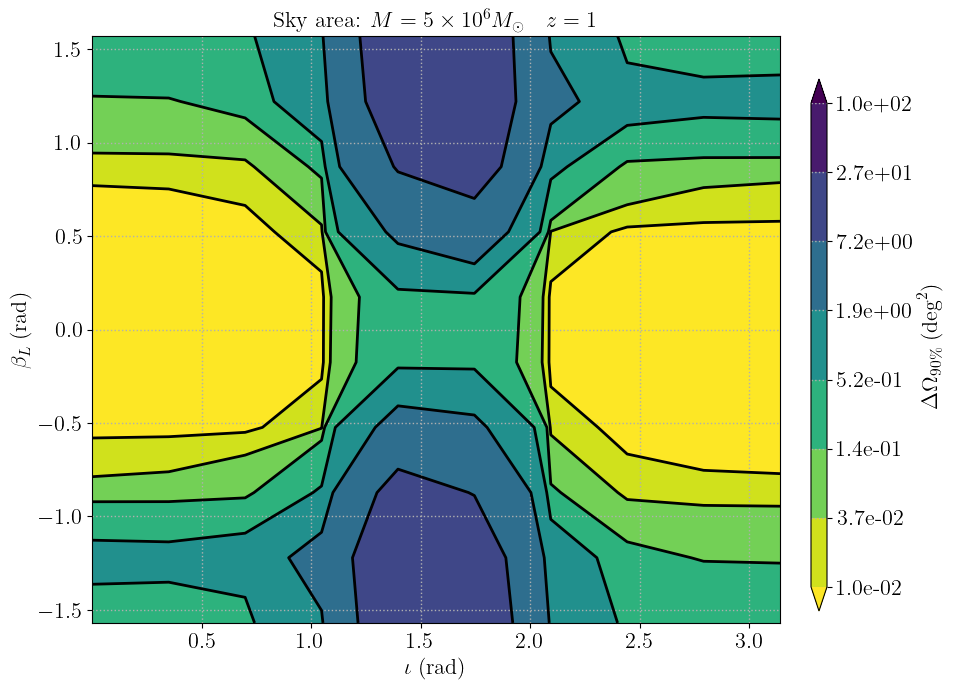

In [124]:
levels_skyarea = np.geomspace(1e-2, 100., 8)

fig, ax = plt.subplots(1,1, figsize=[8,7])

cs = ax.contourf(inc_mesh, betaL_mesh, skyarea90_mesh, levels_skyarea, norm=mpl.colors.LogNorm(), extend='both', cmap=mpl.cm.get_cmap('viridis_r'))
ax.contour(inc_mesh, betaL_mesh, skyarea90_mesh, levels_skyarea, colors='k', linewidths=2)
cb_ax = fig.add_axes([1.02, 0.12, 0.02, 0.76]) # left, bottom, width, height
cbar = fig.colorbar(cs, cax=cb_ax, ticks=levels_skyarea, format='%.1e')
cbar.ax.set_ylabel(r'$\Delta\Omega_{90\%} \; (\mathrm{deg}^2)$', fontsize=16)
#cbar.ax.set_yticklabels([r'$10$', r'$20$', r'$50$', r'$200$', r'$500$', r'$1000$', r'$3000$'], fontsize=16)
plt.subplots_adjust(wspace=0.15)
# manual_locations = [(3e3, 15), (5e3, 17), (1.5e4, 10), (7e4, 4), (2e5, 3), (4e5, 2.5), (5e5, 1.5)]
# ax.clabel(cs, inline=1, fontsize=16, fmt='%3.0f', manual=manual_locations)
ax.set_xlabel(r'$\iota \; (\mathrm{rad})$')
ax.set_ylabel(r'$\beta_L \; (\mathrm{rad})$')
ax.set_title(r'Sky area: $M=5\times 10^6 M_\odot \quad z=1$')

fig.tight_layout()

## Pre-merger Fisher sky localization

In [125]:
params = {
    # Total *redshifted* mass M=m1+m2, solar masses
    "M": 1e5,
    # Mass ratio q=m1/m2
    "q": 4.0,
    # Dimensionless spin component 1 along orbital momentum
    "chi1": 0.7,
    # Dimensionless spin component 2 along orbital momentum
    "chi2": 0.4,
    # Time shift of coalescence, s -- coalescence is at t0*yr + Deltat*s, t0 in waveform_params
    "Deltat": 0.0,
    # Luminosity distance, Mpc
    "dist": cosmo.luminosity_distance(0.3).value,
    # Inclination, observer's colatitude in source-frame
    "inc": 1.0471975511965976,
    # Phase, observer's longitude in source-frame
    "phi": 1.2,
    # Longitude in the sky
    "lambda": 0.5,
    # Latitude in the sky
    "beta": 0.9,
    # Polarization angle
    "psi": 2.7,
    # Flag indicating whether angles and Deltat pertain to the L-frame or SSB-frame
    "Lframe": True
  }

In [126]:
#NOTE: the 'DeltatL_cut' parameter (in s) represents a cut in data, a certain time before the merger reaches LISA

list_params = ['Mchirp', 'q', 'chip', 'chim', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi']

day = 86400.
timetomerger_vals = np.geomspace(600., 30*day, 40)
skyarea90_t_vals = np.zeros_like(timetomerger_vals)
for i,t in enumerate(tqdm(timetomerger_vals)):
    waveform_params_tcut = copy.deepcopy(waveform_params)
    waveform_params_tcut['DeltatL_cut'] = -t
    fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=['log', 10000], steps=None, list_params=list_params, Lframe=True, **waveform_params_tcut)
    skyarea90_t_vals[i] = lisatools.sky_area_cov(fishercov, sq_deg=True, n_sigma=None, prob=0.90)

100%|██████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.56it/s]


Text(0, 0.5, '$\\Delta\\Omega_{90\\%} \\; (\\mathrm{deg}^2)$')

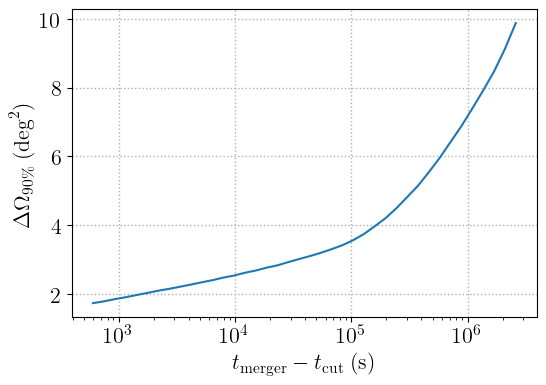

In [127]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.plot(timetomerger_vals, skyarea90_t_vals)
ax.set_xscale('log')
ax.set_xlabel(r'$t_{\rm merger} - t_{\rm cut} \; (\mathrm{s})$')
ax.set_ylabel(r'$\Delta\Omega_{90\%} \; (\mathrm{deg}^2)$')

# Sky multimodality: a simple measure

From the expression of the LISA TDI response, one can see that in the limit where one ignores both the motion of LISA and the high-frequency effects in the response, the following secondary modes in the sky are exactly degenerate:
$$ (\beta_L, \iota, \psi_L) \rightarrow (-\beta_L, \pi-\iota, \pi - \psi_L) $$
$$ (\lambda_L, \psi_L) \rightarrow (\lambda_L + k \frac{\pi}{2}, \psi_L + k \frac{\pi}{2}) $$

This forms 8 potential degenerate sky location where the posterior might have support, which we label as (for k=0,1,2,3):
$$\mathrm{skymode}(1,k) \rightarrow (\beta_L, \iota, \lambda_L + k \frac{\pi}{2}, \psi_L + k \frac{\pi}{2})$$
$$\mathrm{skymode}(-1,k) \rightarrow (-\beta_L, \pi - \iota, \lambda_L + k \frac{\pi}{2}, \pi - \psi_L + k \frac{\pi}{2})$$

In [128]:
params = {
    # Total *redshifted* mass M=m1+m2, solar masses
    "M": 5e6,
    # Mass ratio q=m1/m2
    "q": 4.0,
    # Dimensionless spin component 1 along orbital momentum
    "chi1": 0.7,
    # Dimensionless spin component 2 along orbital momentum
    "chi2": 0.4,
    # Time shift of coalescence, s -- coalescence is at t0*yr + Deltat*s, t0 in waveform_params
    "Deltat": 0.0,
    # Luminosity distance, Mpc
    "dist": cosmo.luminosity_distance(6).value,
    # Inclination, observer's colatitude in source-frame
    "inc": 1.0471975511965976,
    # Phase, observer's longitude in source-frame
    "phi": 1.2,
    # Longitude in the sky
    "lambda": 0.5,
    # Latitude in the sky
    "beta": 0.9,
    # Polarization angle
    "psi": 2.7,
    # Flag indicating whether angles and Deltat pertain to the L-frame or SSB-frame
    "Lframe": True
  }

In [129]:
skymodes = [(1,0), (-1,0), (1,1), (-1,1), (1,2), (-1,2), (1,3), (-1,3)]

In [130]:
likelihood = lisa.LikelihoodLISASMBH(params, **waveform_params)

In [131]:
lisatools.func_loglikelihood_skymodes(likelihood)

{(1, 0): -2.3283064365386963e-10,
 (-1, 0): -1.2197428061626852,
 (1, 1): -533.7968161312165,
 (-1, 1): -534.3391834110953,
 (1, 2): -1061.9610051735071,
 (-1, 2): -1059.7861311220913,
 (1, 3): -534.4395742332563,
 (-1, 3): -534.9276103643933}

In [132]:
maxf_vals = np.geomspace(1e-4, 1e-2, 100)

snr_vals = np.zeros_like(maxf_vals)
lnL_skymodes_vals = {}
for skymode in skymodes:
    lnL_skymodes_vals[skymode] = np.zeros_like(maxf_vals)
for i,maxf in enumerate(tqdm(maxf_vals)):
    waveform_params_maxf = copy.deepcopy(waveform_params)
    waveform_params_maxf['maxf'] = maxf
    likelihood = lisa.LikelihoodLISASMBH(params, **waveform_params_maxf)
    snr_vals[i] = likelihood.tdisignal_inj['SNR']
    lnL_skymodes = lisatools.func_loglikelihood_skymodes(likelihood)
    for skymode in skymodes:
        lnL_skymodes_vals[skymode][i] = lnL_skymodes[skymode]

100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.26it/s]


Text(0, 0.5, '$\\mathrm{SNR}(f)$')

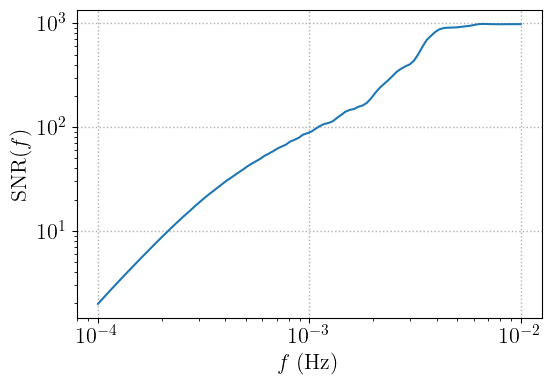

In [133]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.plot(maxf_vals, snr_vals)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$f \; (\mathrm{Hz})$')
ax.set_ylabel(r'$\mathrm{SNR}(f)$')

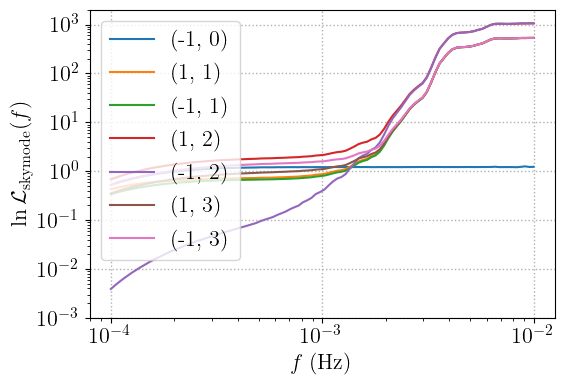

In [134]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
for skymode in skymodes[1:]:
    ax.plot(maxf_vals, -lnL_skymodes_vals[skymode], label=str(skymode))
ax.set_ylim(1e-3, 2e3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$f \; (\mathrm{Hz})$')
ax.set_ylabel(r'$\ln\mathcal{L}_{\rm skymode}(f)$')
ax.legend(loc='upper left')

# Multimodality: Bayesian parameter estimation

## PE results

In [135]:
subsdir = './example_pe/'
datadir = './example_pe/'

In [136]:
subfile = subsdir + 'mbhb_pe_example.json'
postfile = datadir + 'mbhb_pe_example.h5'

params_post = plotutils.load_params_posterior_lisa_smbh(subfile, postfile)

post_raw_file = datadir + 'mbhb_pe_example_raw.h5'

post_raw = {}
with h5py.File(post_raw_file, 'r') as hf:
    for p in params_post['prior_params']['infer_params']:
        post_raw[p] = hf[p][:]
    post_raw['lnL'] = hf['lnlike'][:]

In [137]:
list_params = params_post['prior_params']['infer_params']

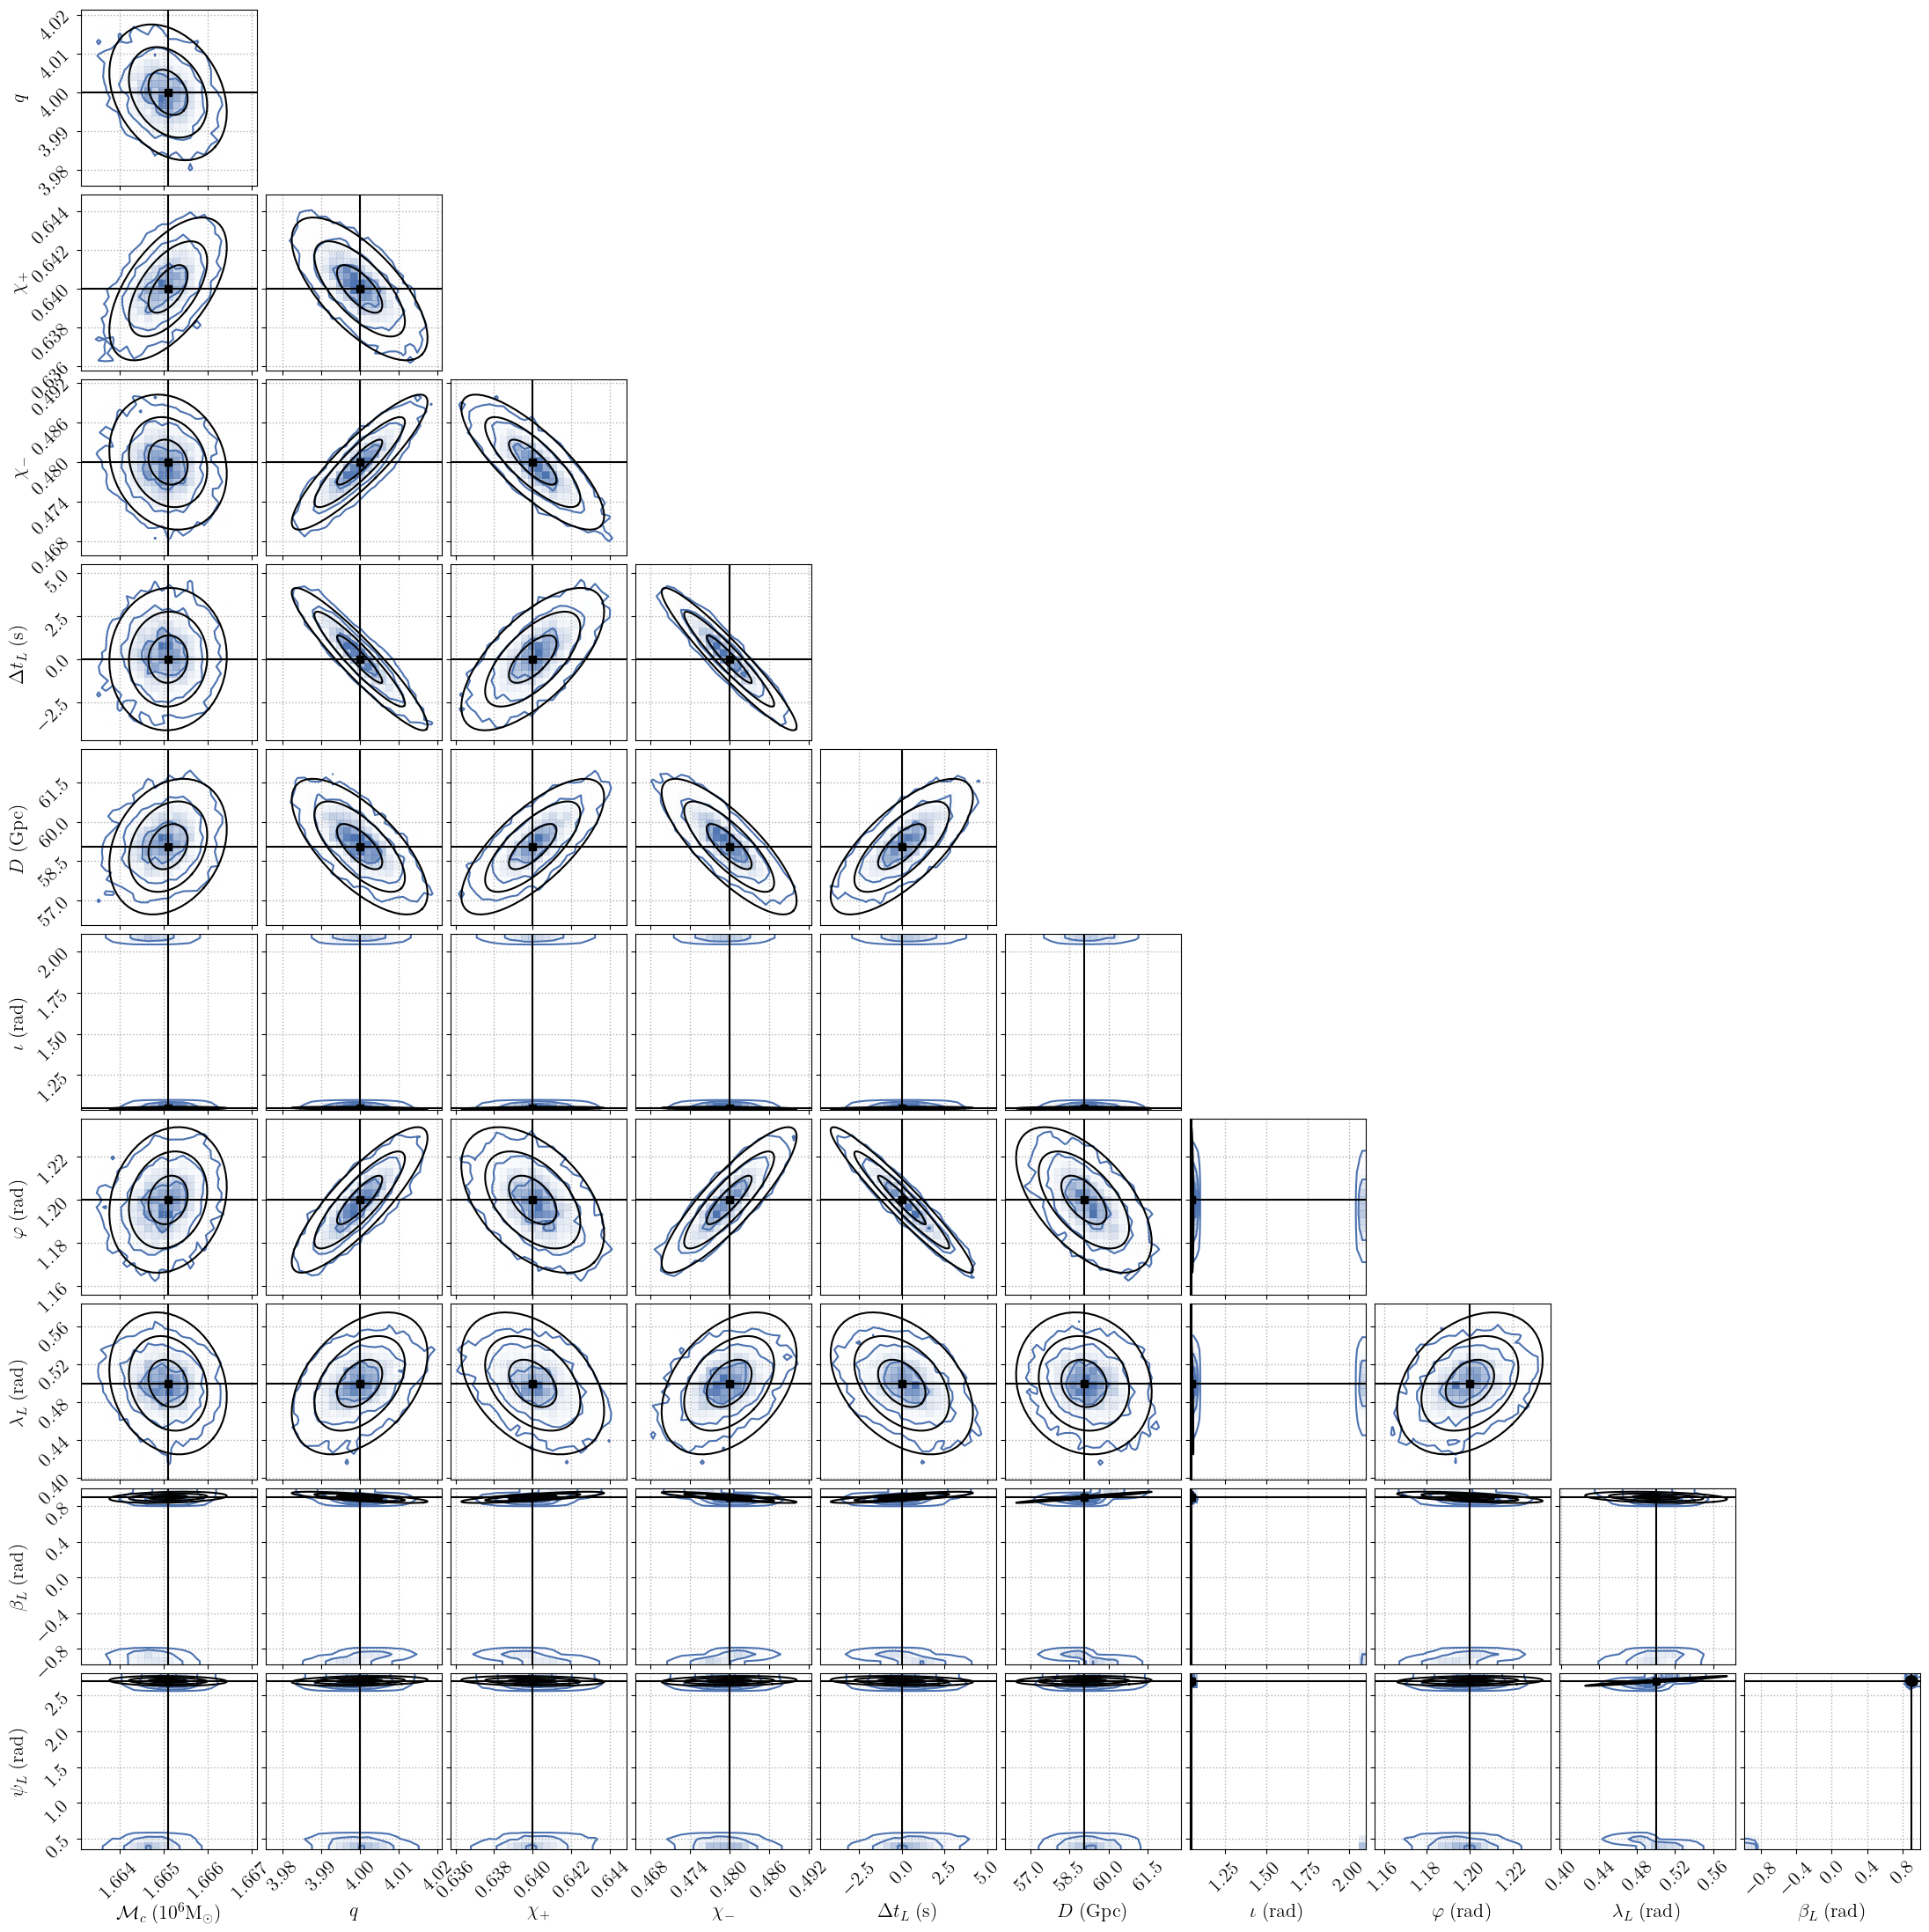

In [138]:
fig = plotutils.corner_plot(params_post['injparams_Lframe'], params_post['post'], output=False, histograms=True, fisher=True, fishercov=params_post['fishercov'], params=['Mchirp', 'q', 'chip', 'chim', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi'], Lframe=True, color=plotutils.plotpalette[0], cov_color='k', show_truths=True, truth_color='k', bins=25, show_histograms=False, plot_datapoints=False);

In [139]:
# Reading off the probability support in the main and secondary modes in the sky, simply counting samples in both
Nsamples = params_post['post']['beta'].shape[0]
np.sum(params_post['post']['beta'] > 0) / Nsamples, np.sum(params_post['post']['beta'] < 0) / Nsamples

(0.626578125, 0.373421875)

## A closer look at the multimodal posterior

In [140]:
mask_main = (params_post['post']['beta'] > 0)
post_main = {}
for p in list_params:
     post_main[p] = params_post['post'][p][mask_main]
post_main['lnL'] = params_post['post']['lnL'][mask_main]
post_main['Lframe'] = params_post['post']['Lframe']
post_main = pytools.complete_all_params(post_main)

mask_reflected = (params_post['post']['beta'] < 0)
post_reflected = {}
for p in list_params:
     post_reflected[p] = params_post['post'][p][mask_reflected]
post_reflected['lnL'] = params_post['post']['lnL'][mask_reflected]
post_reflected['Lframe'] = params_post['post']['Lframe']
post_reflected = pytools.complete_all_params(post_reflected)

imax_reflected = np.argmax(params_post['post']['lnL'][mask_reflected])
params_reflected_maxlnL = {}
for p in list_params:
     params_reflected_maxlnL[p] = post_reflected[p][imax_reflected]
params_reflected_maxlnL['Lframe'] = params_post['post']['Lframe']
params_reflected_maxlnL = pytools.complete_all_params(params_reflected_maxlnL)

# Apply the transformation betaL->-betaL, inc->pi-inc, psiL->pi-psiL
params_reflected = lisatools.jump_params_skymode(params, (-1,0))

In [141]:
# For visualization, apply the transformation betaL->-betaL, inc->pi-inc, psiL->pi-psiL
post_reflected_plt = lisatools.jump_params_skymode(post_reflected, (-1,0))
params_reflected_maxlnL_plt = lisatools.jump_params_skymode(params_reflected_maxlnL, (-1,0))

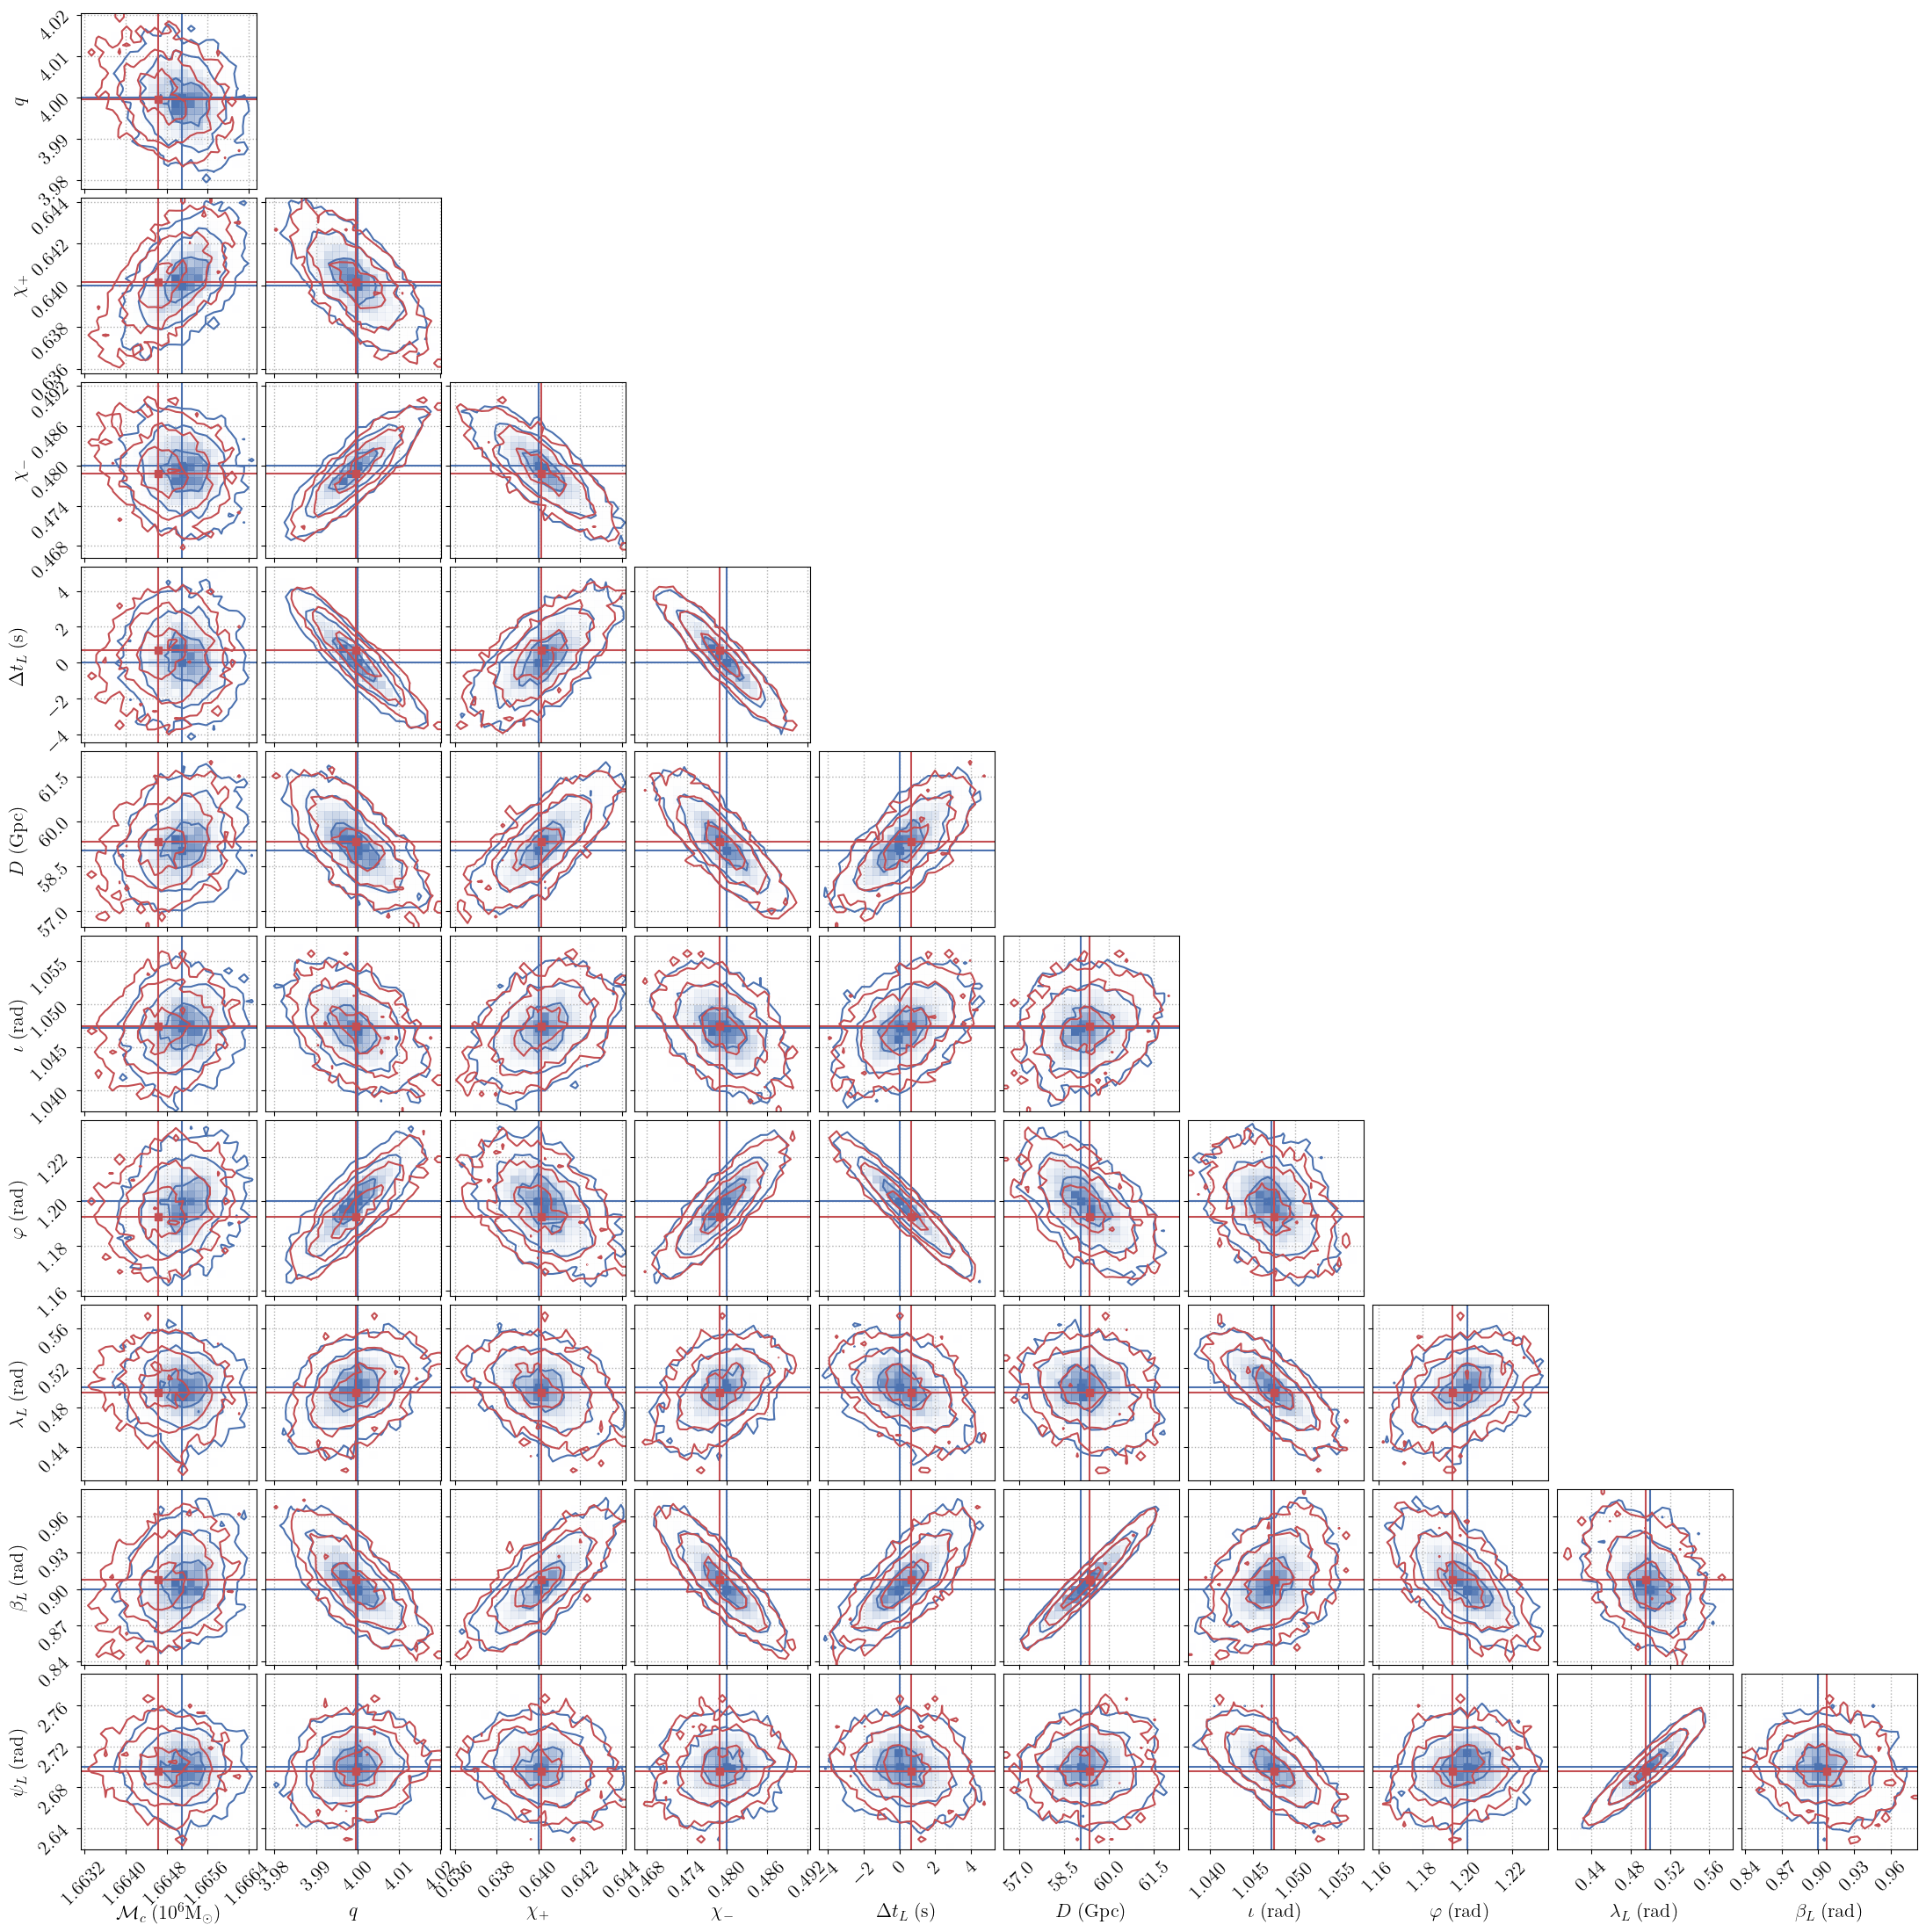

In [142]:
fig = plotutils.corner_plot(params_post['injparams_Lframe'], post_main, output=False, histograms=True, fisher=False, fishercov=None, add_posteriors=[post_reflected_plt], add_truths=[params_reflected_maxlnL_plt], params=list_params, Lframe=True, color=plotutils.plotpalette[0], add_colors=[plotutils.plotpalette[1]], add_truth_colors=[plotutils.plotpalette[1]], cov_color='k', show_truths=True, truth_color=plotutils.plotpalette[0], bins=25, show_histograms=False, plot_datapoints=False);

## Sky modes: going beyond the simple lnL estimate

In [143]:
likelihood = lisa.LikelihoodLISASMBH(params, **waveform_params)

In [144]:
lisatools.func_loglikelihood_skymodes(likelihood)

{(1, 0): -2.3283064365386963e-10,
 (-1, 0): -1.2197428061626852,
 (1, 1): -533.7968161312165,
 (-1, 1): -534.3391834110953,
 (1, 2): -1061.9610051735071,
 (-1, 2): -1059.7861311220913,
 (1, 3): -534.4395742332563,
 (-1, 3): -534.9276103643933}

In [145]:
# Estimating the probablity in each mode of a multi-Gaussian, from the determinant of their covariance and their peak value
def p_multi_gaussian(lambdas, detSigmas):
    p0 = 1. / np.sum([np.sqrt(detSigmas[k] / detSigmas[0]) * np.exp(-lambdas[k]) for k in range(len(lambdas))])
    pks = np.array([p0 * np.sqrt(detSigmas[k] / detSigmas[0]) * np.exp(-lambdas[k]) for k in range(len(lambdas))])
    return pks

In [146]:
detSigmas = [np.linalg.det(np.cov(np.array([post_main[p] for p in list_params]))), np.linalg.det(np.cov(np.array([post_reflected[p] for p in list_params])))]
detSigmas

[1.65781267509601e-35, 1.931260148967393e-35]

In [147]:
likelihood.lnL(params_reflected), likelihood.lnL(params_reflected_maxlnL)

(-1.2197428061626852, -1.0305278153973632)

In [148]:
# Better agreement considering the maxlnL of the secondary mode; just jumping from the main mode using the symmetry is approximate
# NOTE: we would get a better answer using the acutal maxlnL on the secondary mode, obtained through optimization and not simply extracted from the chains
p_multi_gaussian([0., -likelihood.lnL(params_reflected)], detSigmas), p_multi_gaussian([0., -likelihood.lnL(params_reflected_maxlnL)], detSigmas)

(array([0.75830443, 0.24169557]), array([0.72195724, 0.27804276]))

# Where does the sky localization information come from ? Exploring response approximations 

## TDI transfer functions

In [149]:
approx_list = ['frozen-lowf', 'lowf', 'frozen', 'full']

def waveform_params_approx(waveform_params, approx):
    waveform_params_approx = copy.deepcopy(waveform_params)
    if approx=='frozen-lowf':
        waveform_params_approx['frozenLISA'] = True
        waveform_params_approx['responseapprox'] = 'lowfL'
    elif approx=='lowf':
        waveform_params_approx['frozenLISA'] = False
        waveform_params_approx['responseapprox'] = 'lowfL'
    elif approx=='frozen':
        waveform_params_approx['frozenLISA'] = True
        waveform_params_approx['responseapprox'] = 'full'
    elif approx=='full':
        waveform_params_approx['frozenLISA'] = False
        waveform_params_approx['responseapprox'] = 'full'
    else:
        raise ValueError('approx not recognized.')
    return waveform_params_approx

In [150]:
params = {
    # Total *redshifted* mass M=m1+m2, solar masses
    "M": 5e6,
    # Mass ratio q=m1/m2
    "q": 4.0,
    # Dimensionless spin component 1 along orbital momentum
    "chi1": 0.7,
    # Dimensionless spin component 2 along orbital momentum
    "chi2": 0.4,
    # Time shift of coalescence, s -- coalescence is at t0*yr + Deltat*s, t0 in waveform_params
    "Deltat": 0.0,
    # Luminosity distance, Mpc
    "dist": cosmo.luminosity_distance(1.).value,
    # Inclination, observer's colatitude in source-frame
    "inc": 1.0471975511965976,
    # Phase, observer's longitude in source-frame
    "phi": 1.2,
    # Longitude in the sky
    "lambda": 0.5,
    # Latitude in the sky
    "beta": 0.9,
    # Polarization angle
    "psi": 2.7,
    # Flag indicating whether angles and Deltat pertain to the L-frame or SSB-frame
    "Lframe": True
  }

In [151]:
# Parameters for the waveform generation and other options

waveform_params = {
    # Frequency range
    "minf": 1e-5,
    "maxf": 0.5,
    # Reference epoch of coalescence, yr -- coalescence is at t0*yr + Deltat*s, Deltat in params
    "t0": 0.0,
    # Always cut signals timetomerger_max*yr before merger -- to avoid needlessly long signals using minf
    "timetomerger_max": 2.0,
    # Option to cut the signal pre-merger -- must be in L-frame
    "DeltatL_cut": None,
    # Further options to cut signals
    "fstart22": None,
    "fend22": None,
    "tmin": None,
    "tmax": None,
    # TDI channels to generate
    "TDI": "TDIAET",
    # Internal accuracy params
    "order_fresnel": 0,
    # Waveform approximant and set of harmonics to use
    "approximant": "IMRPhenomXHM",
    "modes": None,
    # LISA response options
    "LISAconst": "Proposal",
    "responseapprox": "full",
    "frozenLISA": False,
    "TDIrescaled": True,
    # Noise options -- can also be given as a numpy array for interpolation
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": True,
        "WDduration" : 4.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
  }

In [152]:
M_list = ['M1e4', 'M1e5', 'M1e6', 'M1e7']

def params_of_M(Mstr):
    params_M = copy.deepcopy(params)
    params_M['M'] = float(Mstr[1:])
    return params_M

In [153]:
wftdi = {}
for Mstr in M_list:
    wftdi[Mstr] = {}
    for approx in approx_list:
        wftdi[Mstr][approx] = lisa.GenerateLISATDI_SMBH(params_of_M(Mstr), **waveform_params_approx(waveform_params, approx))

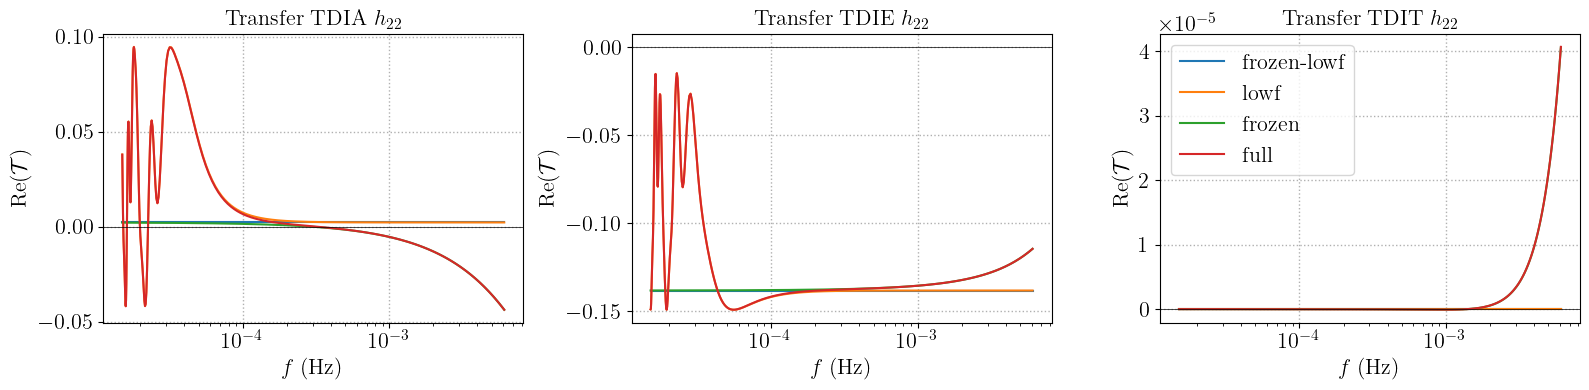

In [154]:
Mstr = 'M1e7'

# Transfer functions, mode h22 (NOTE: rescaled by (6*pi*f*L/c))
titles = ['Transfer TDIA $h_{22}$', 'Transfer TDIE $h_{22}$', 'Transfer TDIT $h_{22}$']
lm = (2,2)

L = 2.5e9
rescaling = 1./(6*np.pi*wftdi[Mstr][approx][(2,2)]['freq']*L/pyconstants.C_SI)

fig, axs = plt.subplots(1,3, figsize=[16,4])
for i in range(3):
    transferstr = 'transferL' + str(i+1)
    for approx in approx_list:
        axs[i].plot(wftdi[Mstr][approx][lm]['freq'], np.real(wftdi[Mstr][approx][lm][transferstr]) * rescaling, label=approx)
        # axs[i].plot(wftdi[Mstr][approx][lm]['freq'], np.imag(wftdi[Mstr][approx][lm][transferstr]) * rescaling)
    axs[i].set_xscale('log')
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_ylabel(r'$\mathrm{Re} (\mathcal{T})$')
    axs[i].axhline(0., lw=0.5, c='k')
    axs[i].set_title(r'' + titles[i])
axs[2].legend(loc='upper left')
fig.tight_layout()

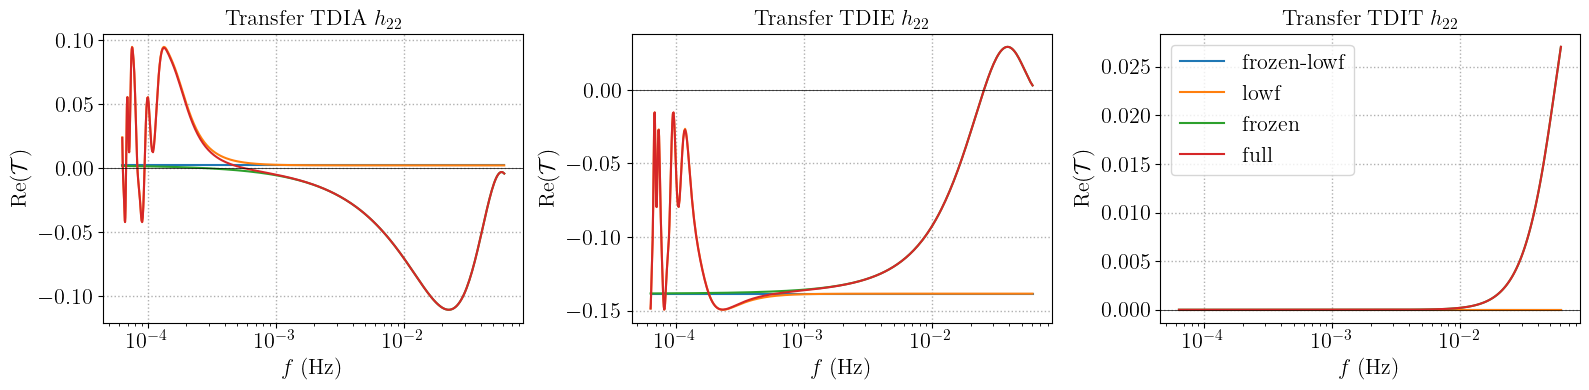

In [155]:
Mstr = 'M1e6'

# Transfer functions, mode h22 (NOTE: rescaled by (6*pi*f*L/c))
titles = ['Transfer TDIA $h_{22}$', 'Transfer TDIE $h_{22}$', 'Transfer TDIT $h_{22}$']
lm = (2,2)

L = 2.5e9
rescaling = 1./(6*np.pi*wftdi[Mstr][approx][(2,2)]['freq']*L/pyconstants.C_SI)

fig, axs = plt.subplots(1,3, figsize=[16,4])
for i in range(3):
    transferstr = 'transferL' + str(i+1)
    for approx in approx_list:
        axs[i].plot(wftdi[Mstr][approx][lm]['freq'], np.real(wftdi[Mstr][approx][lm][transferstr]) * rescaling, label=approx)
        # axs[i].plot(wftdi[Mstr][approx][lm]['freq'], np.imag(wftdi[Mstr][approx][lm][transferstr]) * rescaling)
    axs[i].set_xscale('log')
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_ylabel(r'$\mathrm{Re} (\mathcal{T})$')
    axs[i].axhline(0., lw=0.5, c='k')
    axs[i].set_title(r'' + titles[i])
axs[2].legend(loc='upper left')
fig.tight_layout()

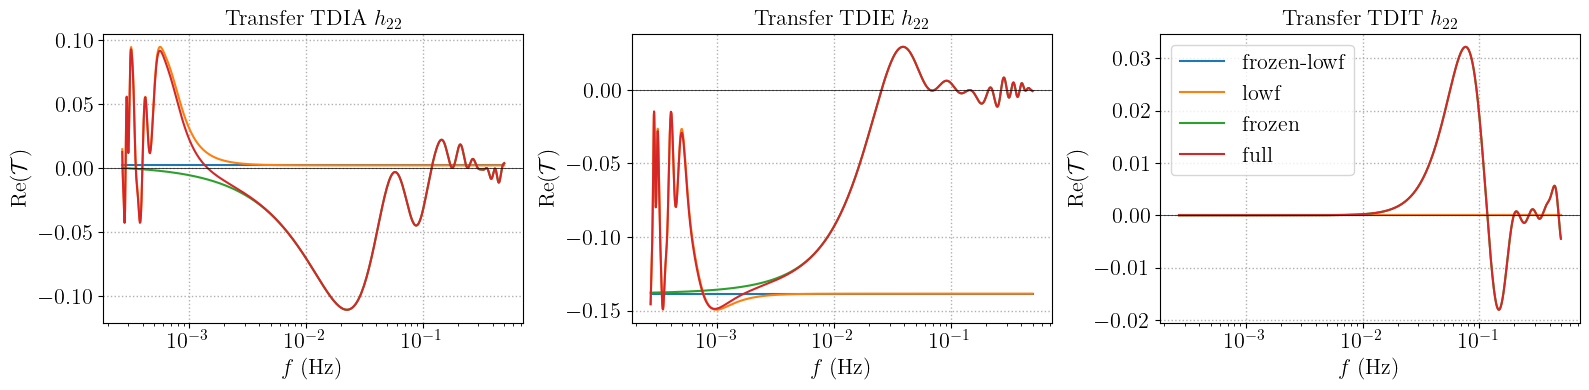

In [156]:
Mstr = 'M1e5'

# Transfer functions, mode h22 (NOTE: rescaled by (6*pi*f*L/c))
titles = ['Transfer TDIA $h_{22}$', 'Transfer TDIE $h_{22}$', 'Transfer TDIT $h_{22}$']
lm = (2,2)

L = 2.5e9
rescaling = 1./(6*np.pi*wftdi[Mstr][approx][(2,2)]['freq']*L/pyconstants.C_SI)

fig, axs = plt.subplots(1,3, figsize=[16,4])
for i in range(3):
    transferstr = 'transferL' + str(i+1)
    for approx in approx_list:
        axs[i].plot(wftdi[Mstr][approx][lm]['freq'], np.real(wftdi[Mstr][approx][lm][transferstr]) * rescaling, label=approx)
        # axs[i].plot(wftdi[Mstr][approx][lm]['freq'], np.imag(wftdi[Mstr][approx][lm][transferstr]) * rescaling)
    axs[i].set_xscale('log')
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_ylabel(r'$\mathrm{Re} (\mathcal{T})$')
    axs[i].axhline(0., lw=0.5, c='k')
    axs[i].set_title(r'' + titles[i])
axs[2].legend(loc='upper left')
fig.tight_layout()

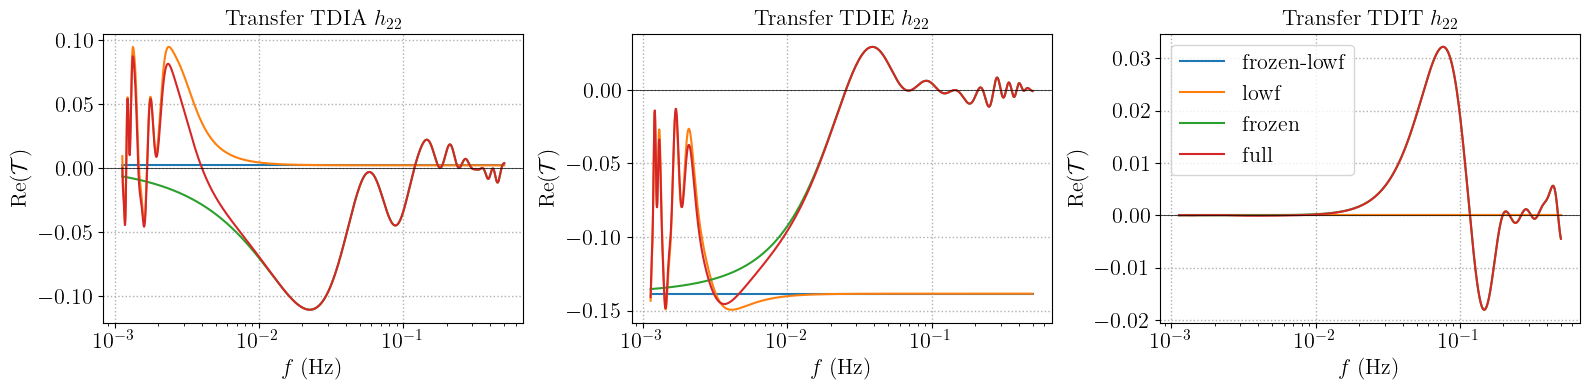

In [157]:
Mstr = 'M1e4'

# Transfer functions, mode h22 (NOTE: rescaled by (6*pi*f*L/c))
titles = ['Transfer TDIA $h_{22}$', 'Transfer TDIE $h_{22}$', 'Transfer TDIT $h_{22}$']
lm = (2,2)

L = 2.5e9
rescaling = 1./(6*np.pi*wftdi[Mstr][approx][(2,2)]['freq']*L/pyconstants.C_SI)

fig, axs = plt.subplots(1,3, figsize=[16,4])
for i in range(3):
    transferstr = 'transferL' + str(i+1)
    for approx in approx_list:
        axs[i].plot(wftdi[Mstr][approx][lm]['freq'], np.real(wftdi[Mstr][approx][lm][transferstr]) * rescaling, label=approx)
        # axs[i].plot(wftdi[Mstr][approx][lm]['freq'], np.imag(wftdi[Mstr][approx][lm][transferstr]) * rescaling)
    axs[i].set_xscale('log')
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_ylabel(r'$\mathrm{Re} (\mathcal{T})$')
    axs[i].axhline(0., lw=0.5, c='k')
    axs[i].set_title(r'' + titles[i])
axs[2].legend(loc='upper left')
fig.tight_layout()

## Fisher sky localization

In [158]:
fishercov = {}
sky_area = {}
for Mstr in M_list:
    fishercov[Mstr] = {}
    sky_area[Mstr] = {}
    for approx in approx_list:
        fishercov[Mstr][approx] = lisa_fisher.fisher_covariance_smbh(params_of_M(Mstr), freqs=['log', 10000], steps=None, list_params=list_params, Lframe=True, **waveform_params_approx(waveform_params, approx))
        sky_area[Mstr][approx] = lisatools.sky_area_cov(fishercov[Mstr][approx], sq_deg=True, n_sigma=None, prob=0.90)

In [159]:
sky_area

{'M1e4': {'frozen-lowf': 62060.29102012145,
  'lowf': 18.058813363363193,
  'frozen': 1083.974456520036,
  'full': 19.23389978844591},
 'M1e5': {'frozen-lowf': 332.421098689005,
  'lowf': 39.46641604911089,
  'frozen': 24.290000001426595,
  'full': 15.884071654048956},
 'M1e6': {'frozen-lowf': 2.8493862330498354,
  'lowf': 2.7762956359276556,
  'frozen': 0.7191810116954435,
  'full': 0.7123859740722859},
 'M1e7': {'frozen-lowf': 0.46546353562060766,
  'lowf': 0.46649539481732105,
  'frozen': 0.28691983453707187,
  'full': 0.2872774047057157}}

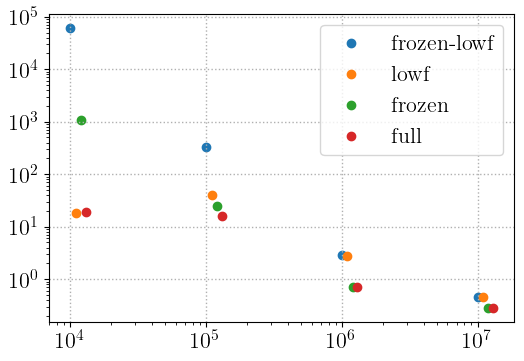

In [160]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
for i,approx in enumerate(approx_list):
    ax.scatter(np.array([params_of_M(Mstr)['M'] * (1 + 0.1*i) for Mstr in M_list]), np.array([sky_area[Mstr][approx] for Mstr in M_list]), label=approx)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper right')

## Sky multimodality degeneracies

In [161]:
skymodes = [(1,0), (-1,0), (1,1), (-1,1), (1,2), (-1,2), (1,3), (-1,3)]

In [162]:
lnL_skymodes = {}
for Mstr in M_list:
    lnL_skymodes[Mstr] = {}
    for approx in approx_list:
        likelihood = lisa.LikelihoodLISASMBH(params_of_M(Mstr), **waveform_params_approx(waveform_params, approx))
        lnL_skymodes[Mstr][approx] = lisatools.func_loglikelihood_skymodes(likelihood)

In [163]:
lnL_skymodes

{'M1e4': {'frozen-lowf': {(1, 0): 0.0,
   (-1, 0): 1.8189894035458565e-12,
   (1, 1): 0.0,
   (-1, 1): 0.0,
   (1, 2): -9.094947017729282e-13,
   (-1, 2): 9.094947017729282e-13,
   (1, 3): 9.094947017729282e-13,
   (-1, 3): 9.094947017729282e-13},
  'lowf': {(1, 0): 1.8189894035458565e-12,
   (-1, 0): -1623.4520492302245,
   (1, 1): -718.6338304113269,
   (-1, 1): -2651.9856560740996,
   (1, 2): -3999.7154266792713,
   (-1, 2): -4541.640789038493,
   (1, 3): -3945.870879214195,
   (-1, 3): -7058.964643048279},
  'frozen': {(1, 0): 9.094947017729282e-13,
   (-1, 0): 1.8189894035458565e-12,
   (1, 1): -25.259880438331493,
   (-1, 1): -25.259880438330583,
   (1, 2): -37.6721897172888,
   (-1, 2): -37.6721897172888,
   (1, 3): -23.52121280530082,
   (-1, 3): -23.52121280530173},
  'full': {(1, 0): 0.0,
   (-1, 0): -1602.2368475862322,
   (1, 1): -706.5177145988023,
   (-1, 1): -2621.0078815893276,
   (1, 2): -3958.988606320736,
   (-1, 2): -4491.110376034012,
   (1, 3): -3793.4243553009233

Text(0.5, 1.0, 'Value of $-\\ln\\mathcal{L}$ at reflected skymode (-1,0)')

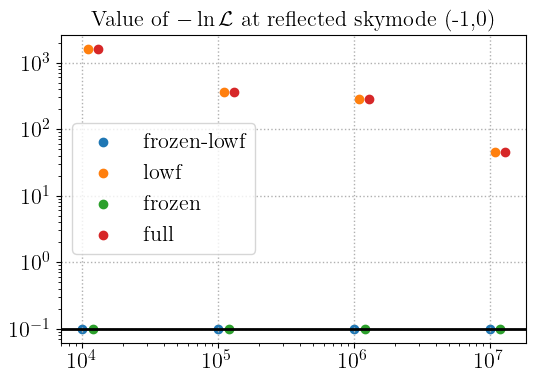

In [164]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
for i,approx in enumerate(approx_list):
    ax.scatter(np.array([params_of_M(Mstr)['M'] * (1 + 0.1*i) for Mstr in M_list]), -np.array([np.fmin(lnL_skymodes[Mstr][approx][(-1,0)], -0.1) for Mstr in M_list]), label=approx)
ax.set_xscale('log')
ax.set_yscale('log')
ax.axhline(0.1, lw=2, c='k')
ax.legend(loc='center left')
ax.set_title(r'Value of $-\ln\mathcal{L}$ at reflected skymode (-1,0)')

Text(0.5, 1.0, 'Value of $-\\ln\\mathcal{L}$ for other skymodes (max)')

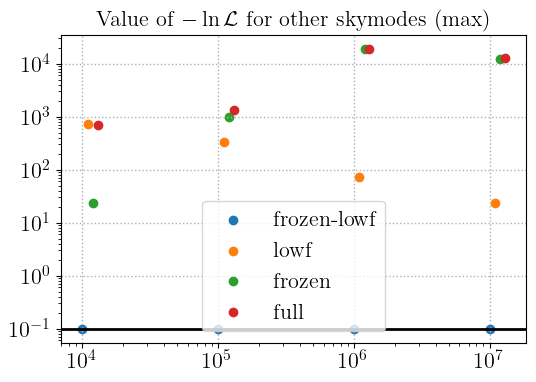

In [165]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
for i,approx in enumerate(approx_list):
    ax.scatter(np.array([params_of_M(Mstr)['M'] * (1 + 0.1*i) for Mstr in M_list]), -np.array([np.max([np.fmin(lnL_skymodes[Mstr][approx][skymode], -0.1) for skymode in skymodes[2:]]) for Mstr in M_list]), label=approx)
ax.set_xscale('log')
ax.set_yscale('log')
ax.axhline(0.1, lw=2, c='k')
ax.legend(loc='lower center')
ax.set_title(r'Value of $-\ln\mathcal{L}$ for other skymodes (max)')